# 공유오피스 출입 데이터 분석

* 공유 오피스의 출입 데이터를 바탕으로 비즈니스 지표의 추이를 예측하여  
서비스의 개선 방향성을 제시하는 프로젝트

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 데이터 확인

| #   | 테이블명           | 테이블 설명            | 주요컬럼                                           |
|-----|--------------------|-----------------------|----------------------------------------------------|
| 1   | trial_register     | 3일체험 신청           | 유저id, 3일체험신청일시                              |
| 2   | trial_visit_info   | 3일체험 신청자 일자별 방문기록  | 유저id, 날짜, 지점id, 최초입실시각, 최종퇴실시각, 체류시간  |
| 3   | trial_access_log   | 3일체험 신청자 출입기록   | 유저id, 지점id, timestamp, 출입방향                  |
| 4   | trial_payment      | 3일체험 신청자 결제 여부   | 유저id, 결제여부                                    |
| 5   | site_area          | 지점별 면적            | 지점id, 지점 면적                                    |


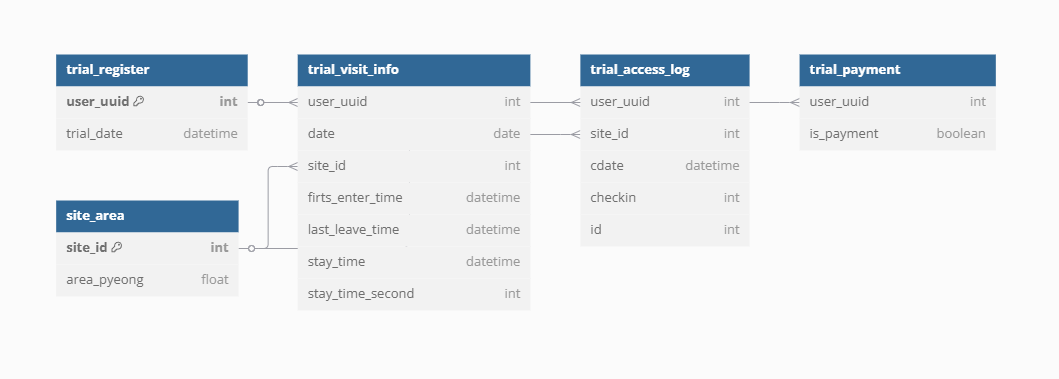

In [3]:
site_area = pd.read_csv("site_area.csv")
trial_access_log = pd.read_csv("trial_access_log.csv")
trial_payment = pd.read_csv("trial_payment.csv")
trial_register = pd.read_csv("trial_register.csv")
trial_visit_info = pd.read_csv("trial_visit_info.csv")

### 1. 공간 면적 데이터 확인

In [4]:
site_area

,site_id,area_pyeong
0,1,50
1,2,100
2,3,150
3,4,100
4,5,150
5,6,150
6,17,50
7,47,50
8,49,50


### 2. 신청자 출입기록 확인

In [5]:
# checkin 입실 : 1 , 퇴실 : 2
trial_access_log.head()

,id,checkin,cdate,site_id,user_uuid
0,1719038,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
1,1716702,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
2,1719956,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
3,1716588,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
4,1719649,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89


In [6]:
# 출입 기록 데이터 총 63,708개
print(f"전체 데이터 개수 : {len(trial_access_log)}개\n")

# 출입 id의 고유값 수
print(f"출입 id의 고유값 개수 : {trial_access_log['id'].nunique()}개\n")

# 출입 id의 중복값 수
print(f"출입 id의 중복값 개수 : {trial_access_log['id'].duplicated().sum()}개\n")

# datetime 형태로 변환
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'])

# 출입 기록이 가장 오래된 날짜 및 시간
print(f"최초의 출입 기록 날짜 : {trial_access_log['cdate'].min()}\n")

# 출입 기록이 가장 최근인 날짜 및 시간
print(f"최근 출입 기록 날짜 : {trial_access_log['cdate'].max()}\n")

# 유저의 고유값 수
print(f"3일체험 신청하고 한번이라도 출입 또는 퇴실한 유저의 수 : {trial_access_log['user_uuid'].nunique()}명\n")

전체 데이터 개수 : 63708개

출입 id의 고유값 개수 : 63349개

출입 id의 중복값 개수 : 359개

최초의 출입 기록 날짜 : 2021-05-02 09:42:13.893455

최근 출입 기록 날짜 : 2024-01-01 14:36:13.987243

3일체험 신청하고 한번이라도 출입 또는 퇴실한 유저의 수 : 6026명



### 3. 사용자 결제 여부 데이터

In [7]:
trial_payment.head()

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0


In [8]:
# 전체 데이터 수
print(f'전체 데이터 수 : {len(trial_payment)}개\n')

# 중복 제외 데이터 수
print(f'고유 사용자 수 : {trial_payment['user_uuid'].nunique()}명\n')

# 결제한 사람 수
print(f'결제한 사람 수 : {len(trial_payment[trial_payment['is_payment'] == 1])}명, 전체 대비 38%\n')

# 결제 안 한 사람 수
print(f'결제 안 한 사람 수 : {len(trial_payment[trial_payment['is_payment'] == 0])}명, 전체 대비 62%')

전체 데이터 수 : 9659개

고유 사용자 수 : 9624명

결제한 사람 수 : 3664명, 전체 대비 38%

결제 안 한 사람 수 : 5995명, 전체 대비 62%


### 4. 체험 신청 날짜 확인

In [9]:
trial_register.head()

,trial_date,user_uuid
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0


In [10]:
print(f'신청자 수  : {trial_register['user_uuid'].nunique()}명')

신청자 수  : 9624명


### 5. 사용자 방문 정보

In [11]:
trial_visit_info.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594


In [12]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


In [13]:
# datetime 타입 변환
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'], errors='coerce')
trial_visit_info['stay_time'] = pd.to_datetime(trial_visit_info['stay_time'], errors='coerce')
# 오직 시간만 확인하기 위해 stay_time2라는 컬럼 새롭게 생성
trial_visit_info['stay_time2'] = trial_visit_info['stay_time'].dt.time
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'], errors='coerce')
trial_visit_info['last_leave_time'] = pd.to_datetime(trial_visit_info['last_leave_time'], errors='coerce')

# 3일 체험 신청 후 방문한 유저의 수
print(f"체험 신청하고 한 번이라도 공유오피스에 방문한 유저의 수 : {trial_visit_info['user_uuid'].nunique()}명\n")

C:\Users\seonw\AppData\Local\Temp\ipykernel_24360\1039786921.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trial_visit_info['stay_time'] = pd.to_datetime(trial_visit_info['stay_time'], errors='coerce')


체험 신청하고 한 번이라도 공유오피스에 방문한 유저의 수 : 6534명



In [14]:
trial_visit_info.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
0,1,2023-12-23,2025-03-07 01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,01:11:19.983486
1,1,2023-12-24,2025-03-07 04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,04:35:10.361341
2,1,2023-12-25,2025-03-07 02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,02:09:54.117163
3,1,2023-12-23,2025-03-07 04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,04:37:36.134901
4,3,2023-12-26,2025-03-07 04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,04:32:05.289251


# 2. 데이터 결합
시각화 및 데이터 분포를 위한 탐색적 데이터 분석(EDA)을 진행하기 전에 데이터간의 결합이 가능한지 확인 후 데이터 결합을 진행
## 2-1. 결제데이터, 3일 체험 등록데이터 결합
결제데이터(trial_payment)와 등록데이터(trial_register)를 결합하여 하나의 데이터프레임으로 구성한다.
### 1) 결제 데이터 중복 제거 처리

In [15]:
# 결제 데이터는 전체 행이 중복되는 경우만 존재하므로 단순하게 drop_duplicates() 활용해서 중복을 제거
trial_payment_drop = trial_payment.drop_duplicates()
trial_payment_drop # 총 9,624명의 유저 확인

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0
...,...,...
9654,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655,0,43263092-3b28-4817-9fa9-4205ad3097fe
9656,0,51a40f33-1027-4544-9b95-45bca7c104fb
9657,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c


### 2) 3일 체험 등록데이터 중복 제거 처리

In [16]:
# 1. 날짜와 유저id가 완전히 동일한 데이터 중복 제거를 진행
# 이유 : 시간까지 확인되진 않으므로 날짜가 동일한 애들은 전부 삭제해줘도 무관
trial_register_drop = trial_register.drop_duplicates()

# 9,631명의 데이터 존재하지만, 아직 중복되는 값이 더 존재함
print(f"전체 행 기준 중복 제거 후 데이터 개수 : {len(trial_register_drop)}명\n")

# 날짜가 서로 다르지만 유저id가 중복되는 데이터 개수
print(f"날짜가 다르지만, 유저id가 중복되는 데이터 개수 : {len(trial_register_drop[trial_register_drop['user_uuid'].duplicated()])}명")

전체 행 기준 중복 제거 후 데이터 개수 : 9631명

날짜가 다르지만, 유저id가 중복되는 데이터 개수 : 7명


- 전체 행 기준으로 중복을 제거
- 유저id는 동일하지만, 날짜가 다른 중복데이터가 존재
- 유저id를 기준으로 늦게 등록한 데이터를 남겨두고, 이전 중복데이터를 삭제
    - 과거에 무료 이용권을 등록 취소하고, 다시 며칠 뒤에 재등록함
    - 즉, 가장 최신 데이터만 남기도록 중복데이터 제거

In [17]:
# 유저 아이디를 기준으로 중복데이터 확인 후, 가장 최신의 데이터만 남기고 중복데이터를 삭제
trial_register_drop2 = trial_register_drop.drop_duplicates(subset=['user_uuid'], keep='last')

# 최종 데이터 결과
print(f"최종 중복 제거된 trial_register 인원의 수 : {len(trial_register_drop2)}명")

최종 중복 제거된 trial_register 인원의 수 : 9624명


### 3) 데이터 병합

In [18]:
# 중복 제거된 trial_payment 데이터와 trial_register 데이터를 user_uuid 기준으로 병합
register_payment_merged = trial_payment_drop.merge(trial_register_drop2[['user_uuid', 'trial_date']], on='user_uuid', how='left')

# 병합 후 전체 행 중복 여부 확인
print(f"병합 후 데이터 총 개수 확인 : {len(register_payment_merged)}개\n")

# 병합 후 데이터 총 개수 확인
print(f"병합 후 전체 행 중복 여부 확인 : {register_payment_merged.duplicated().sum()}개\n")

# 데이터 프레임 확인
print("병합 된 데이터 예시5개 확인")
display(register_payment_merged.sample(5))

병합 후 데이터 총 개수 확인 : 9624개

병합 후 전체 행 중복 여부 확인 : 0개

병합 된 데이터 예시5개 확인


,is_payment,user_uuid,trial_date
2941,1,fe5da4df-98a5-4150-b76e-2c392cf92985,2022-01-10
8122,0,0511bc58-d8b8-40ab-879e-3fe294a017b2,2023-06-12
9412,1,898efc1e-1ca3-427b-88db-e1cf2b1e4aa1,2023-10-23
6167,1,5f747ad2-a4b5-4039-855e-e5e0e425b7ff,2022-11-14
3590,0,f879c9bc-4fae-4491-aa8e-8bc37611e009,2022-03-21


## 2-2. 출입기록 병합
2-1에서 병합된 등록, 결제여부 데이터(`register_payment_merged`)와 출입기록 데이터(`trial_access_log`)를 병합하여 하나의 데이터 프레임으로 생성
### 1) 출입기록 날짜 데이터 분할
`cdate` 컬럼을 `year(연도)`, `month(월)`, `day(일자)`

In [19]:
# 원본 데이터 카피 후 병합 진행
trial_access_log2 = trial_access_log.copy()

# 날짜, 시간 전부 각개의 컬럼으로 변경, EDA 시각화 활용 예정
trial_access_log2['year'] = trial_access_log2['cdate'].dt.year
trial_access_log2['month'] = trial_access_log2['cdate'].dt.month
trial_access_log2['day'] = trial_access_log2['cdate'].dt.day
trial_access_log2['time'] = trial_access_log2['cdate'].dt.time

# 불필요한 id컬럼 삭제, cdate는 데이터 내림,오름차순에 사용
trial_access_log2 = trial_access_log2.drop(columns=['id'])

# 유저의 출입 기록 확인
trial_access_log2[trial_access_log2['user_uuid'].duplicated()][:10].sort_values('cdate', ascending=True)

,checkin,cdate,site_id,user_uuid,year,month,day,time
3,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,13:09:48.758097
1,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:15:58.761284
5,1,2023-07-06 15:28:39.279318,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:28:39.279318
6,2,2023-07-06 18:17:33.011298,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,18:17:33.011298
8,2,2023-07-07 09:22:36.745763,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,09:22:36.745763
4,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,10:12:42.083352
9,2,2023-07-07 11:09:52.861538,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,11:09:52.861538
7,1,2023-07-07 14:08:25.192590,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:08:25.192590
2,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:10:41.848998
10,1,2023-07-07 14:24:21.501446,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:24:21.501446


#### 한 명의 유저가 일자별로 출입한 기록을 일부 확인한 결과
- 출입 또는 퇴실한 기록이 없을 수 있음
    - 누군가 앞에서 문을 열어주고 뒤따라 들어간 경우
### 2) 유저별 방문 횟수 구하기
유저별로 무료 이용권을 통해 공유오피스에 방문한 횟수 구하기

In [20]:
# 유저ID 별로 그룹화 진행 및 날짜의 고유값 개수 확인
trial_access_log_daycnt = trial_access_log2.groupby('user_uuid')['day'].nunique().reset_index()

# 출입한 날이 많은 순서대로 확인
trial_access_log_daycnt = trial_access_log_daycnt.sort_values('day', ascending=False)

# 가장 많이 방문한 상위 3명 확인
trial_access_log_daycnt.head(3)

,user_uuid,day
1298,351979ce-62c9-4170-ae4f-3fe60a2492ed,4
5409,e53dbfe5-3f4f-4243-8423-5a1ef3ebfcc3,4
1906,4eec8463-d053-44a1-942d-f79e90d3a106,4


### 3) 유저별 공유오피스 입실, 퇴실 총 횟수 구하기

In [21]:
# 각 유저들의 입장, 퇴실 전체 합친 수
access_all_count = trial_access_log['user_uuid'].value_counts()

# 유저id 마다 입장, 퇴실 횟수를 합친 데이터를 access_cnt 컬럼에 입력
trial_access_log_daycnt['access_cnt'] = trial_access_log_daycnt['user_uuid'].map(access_all_count)

# 입장, 퇴실 가장 많이한 상위 3명 확인
trial_access_log_daycnt.sort_values('access_cnt', ascending=False)[:10]

,user_uuid,day,access_cnt
3524,948ae0cc-bc5a-4bd3-89ce-92b2a5c34710,3,126
1844,4c5b26a3-24d4-4b8f-a591-be80271c0aeb,3,108
5263,dfcf88d6-b293-4598-89c0-6598865e3fd9,3,80
2179,5a8723ea-4207-4d94-ab06-d7f7d7de8b61,3,76
1809,4b148aaf-0149-4d63-81ba-0cae91598ff2,3,76
4790,ca76e5bd-5e76-47ff-9ef9-f0fac8b64edd,2,75
1684,4622f625-f93d-4f65-9e9a-e7b24171da62,3,72
2248,5d4058cb-528a-45b1-a2dd-7cf2cc6c401a,3,67
3278,891127aa-959d-4788-a836-dfcc9cf5bfdf,3,67
1065,29787639-0033-4372-acb8-5400e40f9ddd,3,66


### 4) register_payment_merged 데이터와 병합
`register_payment_merged` 데이터에 존재하는 유저가 한 번이라도 공유오피스에 방문하지 않았으면 `day` 와 `access_cnt` 컬럼을 **0**으로 채워준다.

In [22]:
# register_payment_merged 데이터
access_merged = register_payment_merged.merge(trial_access_log_daycnt[['day', 'access_cnt', 'user_uuid']], on='user_uuid', how='left')

In [23]:
access_merged[access_merged['day'].isna()]

,is_payment,user_uuid,trial_date,day,access_cnt
2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,NaN,NaN
5,0,283a7a94-8d9e-477a-beb5-29d4d25e4c10,2023-12-22,NaN,NaN
10,0,3fabc6c1-b2d4-4c30-ba2c-f013c34278bd,2023-12-23,NaN,NaN
21,1,552cf9a3-0038-494c-bc9f-1526b5ba3a29,2023-12-24,NaN,NaN
24,0,6f074d46-3c75-4551-b9e6-e1014bbe5d14,2023-12-24,NaN,NaN
...,...,...,...,...,...
9602,1,7f733742-2b31-4f09-b256-696b611803c7,2023-11-15,NaN,NaN
9605,1,544a3e9e-24e4-4a64-bd5d-da0acaec223a,2023-11-15,NaN,NaN
9613,0,42f82dc9-53c0-44d5-8f55-36bd1a198213,2023-11-14,NaN,NaN
9618,0,6301b10b-9ef2-471d-a179-a6d327bebd9c,2023-11-17,NaN,NaN


# trial_visit_info 데이터 결측치 채우기
## 평균 출입 시간대 구하기
날짜는 주어졌으므로 출입 시간대가 존재하는 데이터에서 평균 출입 시간을 계산하여, 결측치가 존재하는 데이터에 입력
1. 입출입 기록이 없는 유저가 만약 이틀 이상 방문했다면, 다른날 입장한 기록의 데이터를 사용해서 입력해주기_사실 가장 합리적임
2. 입출입이 빈번했던 시간대를 가지고 출입시간대에 넣는 방법도 괜찮음

결측치 계획  
- 출입 시간이 결측치인 경우 퇴실 시간에서 stay_time2를 빼서 구함.  
- 퇴실 시간이 결측치인 경우 충입 시간에서 stay_time2를 더해서 구함.  
- 둘 다 없는 경우 가장 입장,퇴근 시간이 많은 시간으로 입장 시간을 대체해서 체류시간 더해 퇴장 시간 설정  
(이용 시간이 많은 09시와 13시로 나눠서 2 : 3의 비율로 나눠서 최초 출근 시간을 설정할 계획)

In [24]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   site_id           11477 non-null  int64         
 1   date              11477 non-null  datetime64[ns]
 2   stay_time         11477 non-null  datetime64[ns]
 3   stay_time_second  11477 non-null  int64         
 4   first_enter_time  10124 non-null  datetime64[ns]
 5   last_leave_time   10147 non-null  datetime64[ns]
 6   user_uuid         11477 non-null  object        
 7   stay_time2        11477 non-null  object        
dtypes: datetime64[ns](4), int64(2), object(2)
memory usage: 717.4+ KB


In [25]:
# 이용 시간 시간 데이터로 전환
trial_visit_info['stay_time2'] = pd.to_timedelta(trial_visit_info['stay_time2'].astype(str))

In [26]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   site_id           11477 non-null  int64          
 1   date              11477 non-null  datetime64[ns] 
 2   stay_time         11477 non-null  datetime64[ns] 
 3   stay_time_second  11477 non-null  int64          
 4   first_enter_time  10124 non-null  datetime64[ns] 
 5   last_leave_time   10147 non-null  datetime64[ns] 
 6   user_uuid         11477 non-null  object         
 7   stay_time2        11477 non-null  timedelta64[ns]
dtypes: datetime64[ns](4), int64(2), object(1), timedelta64[ns](1)
memory usage: 717.4+ KB


In [27]:
trial_visit_info

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
0,1,2023-12-23,2025-03-07 01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,0 days 01:11:19.983486
1,1,2023-12-24,2025-03-07 04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,0 days 04:35:10.361341
2,1,2023-12-25,2025-03-07 02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,0 days 02:09:54.117163
3,1,2023-12-23,2025-03-07 04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,0 days 04:37:36.134901
4,3,2023-12-26,2025-03-07 04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,0 days 04:32:05.289251
...,...,...,...,...,...,...,...,...
11472,6,2022-06-16,2025-03-07 06:47:59.975925,24479,2022-06-16 11:00:48.643935,2022-06-16 18:23:38.495290,766221e7-a753-444f-aa5a-ae76ce86d3fd,0 days 06:47:59.975925
11473,6,2022-06-17,2025-03-07 01:28:46.221537,5326,2022-06-17 17:15:05.221223,2022-06-17 18:56:00.840639,0a70277f-a7f9-401c-95fa-ed6d96ee32e0,0 days 01:28:46.221537
11474,6,2022-06-16,2025-03-07 05:08:03.166662,18483,2022-06-16 12:52:46.557742,2022-06-16 18:23:34.355309,0a70277f-a7f9-401c-95fa-ed6d96ee32e0,0 days 05:08:03.166662
11475,6,2023-02-06,2025-03-07 06:30:29.693768,23429,2023-02-06 10:14:00.538281,2023-02-06 16:52:37.606175,576473bb-0647-483e-b06a-a5ff6491b08b,0 days 06:30:29.693768


In [28]:
trial_visit_info.isna().sum()

site_id                0
date                   0
stay_time              0
stay_time_second       0
first_enter_time    1353
last_leave_time     1330
user_uuid              0
stay_time2             0
dtype: int64

In [29]:
# 출입 시간 기준으로 내림차순
trial_visit_info = trial_visit_info.sort_values(by = 'date',ascending=False)
trial_visit_info.head(4)

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
65,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182
163,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012
64,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656
92,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848


In [30]:
# 최초입실시간 결측치 처리
# 결측값 채우기 (최종퇴실시각에서 체류시간을 빼서 최초입실시각을 계산)
trial_visit_info['first_enter_time'] = trial_visit_info.apply(
    lambda row: row['last_leave_time'] - row['stay_time2'] if pd.isnull(row['first_enter_time']) else row['first_enter_time'], axis=1
)

In [31]:
# 최종퇴실시각 결측치 처리
# 결측값 채우기 (최초입실시각에서 체류시간을 더해서 최종퇴실시각을 계산)
trial_visit_info['last_leave_time'] = trial_visit_info.apply(
    lambda row: row['first_enter_time'] + row['stay_time2'] if pd.isnull(row['last_leave_time']) else row['last_leave_time'], axis=1
)

In [32]:
trial_visit_info.isna().sum()

site_id               0
date                  0
stay_time             0
stay_time_second      0
first_enter_time    682
last_leave_time     682
user_uuid             0
stay_time2            0
dtype: int64

현재 둘 중 하나만 결측치가 있는 경우는 처리가 되었고 나머지는 둘 다 결측치인 데이터가 총 682개이다.

In [33]:
trial_visit_info

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
65,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182
163,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012
64,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656
92,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848
25,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430
...,...,...,...,...,...,...,...,...
6356,3,2021-05-05,2025-03-07 04:22:01.471049,15721,NaT,NaT,e0e372b4-7f33-498b-ba1a-895aaffe18ff,0 days 04:22:01.471049
6115,3,2021-05-05,2025-03-07 03:27:40.660550,12460,NaT,NaT,ef91f58a-c205-4213-bca8-0adef36e7a24,0 days 03:27:40.660550
3117,3,2021-05-04,2025-03-07 03:58:16.543346,14296,NaT,NaT,22aad31c-1958-4c83-bfde-099d70765447,0 days 03:58:16.543346
2670,1,2021-05-03,2025-03-07 02:22:26.854279,8546,NaT,NaT,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,0 days 02:22:26.854279


In [34]:
user_blank = trial_visit_info[trial_visit_info['first_enter_time'].isna()][['user_uuid']]

In [35]:
user_blank

,user_uuid
158,4ba37b4f-1239-4107-8f03-395dff5da4b8
157,4ba37b4f-1239-4107-8f03-395dff5da4b8
2347,ac797f20-42c9-45e1-8009-ada4d60294ef
2344,c78a069b-2c7c-459d-ab3d-5a8167475e4b
2306,c9fb93af-63dc-48a2-ac11-bfa995bda87d
...,...
6356,e0e372b4-7f33-498b-ba1a-895aaffe18ff
6115,ef91f58a-c205-4213-bca8-0adef36e7a24
3117,22aad31c-1958-4c83-bfde-099d70765447
2670,fce967b5-070c-46ed-a5fa-ef7d298cc7aa


In [36]:
user_blank = user_blank['user_uuid'].drop_duplicates()

In [37]:
user_blank

158     4ba37b4f-1239-4107-8f03-395dff5da4b8
2347    ac797f20-42c9-45e1-8009-ada4d60294ef
2344    c78a069b-2c7c-459d-ab3d-5a8167475e4b
2306    c9fb93af-63dc-48a2-ac11-bfa995bda87d
2253    0c440362-8504-42db-9f94-4363d41dc0d3
                        ...                 
6356    e0e372b4-7f33-498b-ba1a-895aaffe18ff
6115    ef91f58a-c205-4213-bca8-0adef36e7a24
3117    22aad31c-1958-4c83-bfde-099d70765447
2670    fce967b5-070c-46ed-a5fa-ef7d298cc7aa
3619    e079e682-62f2-4c05-84b9-86913e3dc146
Name: user_uuid, Length: 445, dtype: object

In [38]:
trial_access_log2

,checkin,cdate,site_id,user_uuid,year,month,day,time
0,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,07:11:55.201673
1,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:15:58.761284
2,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:10:41.848998
3,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,13:09:48.758097
4,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,10:12:42.083352
...,...,...,...,...,...,...,...,...
63703,2,2023-04-26 09:04:44.770319,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,09:04:44.770319
63704,1,2023-04-26 06:09:14.228682,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,06:09:14.228682
63705,1,2023-11-04 11:50:10.657353,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,11:50:10.657353
63706,2,2023-11-04 13:31:41.599473,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,13:31:41.599473


In [39]:
access_user = pd.merge(trial_access_log2, user_blank,on='user_uuid',how='inner')

In [40]:
access_user

,checkin,cdate,site_id,user_uuid,year,month,day,time
0,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,07:11:55.201673
1,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:15:58.761284
2,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:10:41.848998
3,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,13:09:48.758097
4,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,10:12:42.083352
...,...,...,...,...,...,...,...,...
4855,1,2023-11-04 12:04:49.334086,49,2ea2a495-5a75-4428-a976-ce420507d180,2023,11,4,12:04:49.334086
4856,1,2023-11-04 14:48:31.389401,49,2ea2a495-5a75-4428-a976-ce420507d180,2023,11,4,14:48:31.389401
4857,1,2023-11-04 11:50:10.657353,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,11:50:10.657353
4858,2,2023-11-04 13:31:41.599473,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,13:31:41.599473


In [41]:
access_user['user_uuid'].nunique()

426

In [42]:

# # cdate 열을 datetime 형식으로 변환
# access_user['cdate'] = pd.to_datetime(access_user['cdate'])

# # 각 유저의 가장 최근 퇴실 시간과 가장 오래된 입장 시간을 추출
# most_recent_checkout = access_user[access_user['checkin'] == 2].groupby('user_uuid')['cdate'].max().reset_index()
# most_recent_checkout.columns = ['user_uuid', 'last_leave_time']

# earliest_checkin = access_user[access_user['checkin'] == 1].groupby('user_uuid')['cdate'].min().reset_index()
# earliest_checkin.columns = ['user_uuid', 'first_enter_time']

# # trial_visit_info와 병합하여 결측값 채우기
# df_visit = pd.merge(trial_visit_info, earliest_checkin, on='user_uuid', how='left', suffixes=('', '_new'))
# df_visit['first_enter_time'] = df_visit.apply(lambda row: row['first_enter_time_new'] if pd.isnull(row['first_enter_time']) else row['first_enter_time'], axis=1)
# df_visit.drop('first_enter_time_new', axis=1, inplace=True)

# df_visit['last_leave_time'] = df_visit.apply(
#     lambda row: row['first_enter_time'] + row['stay_time2'] if pd.isnull(row['last_leave_time']) else row['last_leave_time'], axis=1
# )


In [43]:


# cdate 열을 datetime 형식으로 변환
access_user['cdate'] = pd.to_datetime(access_user['cdate'])
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])

# 날짜를 기준으로 필터링
access_user['날짜'] = access_user['cdate'].dt.date
trial_visit_info['날짜'] = trial_visit_info['date'].dt.date

# 각 유저의 가장 최근 퇴실 시간과 가장 오래된 입장 시간을 날짜별로 추출
most_recent_checkout = access_user[access_user['checkin'] == 2].groupby(['user_uuid', '날짜'])['cdate'].max().reset_index()
most_recent_checkout.columns = ['user_uuid', '날짜', 'last_leave_time']

earliest_checkin = access_user[access_user['checkin'] == 1].groupby(['user_uuid', '날짜'])['cdate'].min().reset_index()
earliest_checkin.columns = ['user_uuid', '날짜', 'first_enter_time']

# 날짜를 기준으로 병합하여 결측값 채우기
df_visit = pd.merge(trial_visit_info, earliest_checkin, on=['user_uuid', '날짜'], how='left', suffixes=('', '_new'))
df_visit['first_enter_time'] = df_visit.apply(lambda row: row['first_enter_time_new'] if pd.isnull(row['first_enter_time']) else row['first_enter_time'], axis=1)
df_visit.drop('first_enter_time_new', axis=1, inplace=True)

df_visit['last_leave_time'] = df_visit.apply(
    lambda row: row['first_enter_time'] + row['stay_time2'] if pd.isnull(row['last_leave_time']) else row['last_leave_time'], axis=1
)

df_visit


,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2,날짜
0,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182,2024-01-02
1,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012,2024-01-01
2,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656,2024-01-01
3,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848,2024-01-01
4,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430,2024-01-01
...,...,...,...,...,...,...,...,...,...
11472,3,2021-05-05,2025-03-07 04:22:01.471049,15721,2021-05-05 05:07:50.850192,2021-05-05 09:29:52.321241,e0e372b4-7f33-498b-ba1a-895aaffe18ff,0 days 04:22:01.471049,2021-05-05
11473,3,2021-05-05,2025-03-07 03:27:40.660550,12460,2021-05-05 05:07:48.095251,2021-05-05 08:35:28.755801,ef91f58a-c205-4213-bca8-0adef36e7a24,0 days 03:27:40.660550,2021-05-05
11474,3,2021-05-04,2025-03-07 03:58:16.543346,14296,2021-05-04 04:20:33.600933,2021-05-04 08:18:50.144279,22aad31c-1958-4c83-bfde-099d70765447,0 days 03:58:16.543346,2021-05-04
11475,1,2021-05-03,2025-03-07 02:22:26.854279,8546,2021-05-03 05:20:36.931652,2021-05-03 07:43:03.785931,fce967b5-070c-46ed-a5fa-ef7d298cc7aa,0 days 02:22:26.854279,2021-05-03


In [44]:
df_visit[df_visit['user_uuid'] == '82b11c57-3f45-4e08-a3b1-c840679899f2']

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2,날짜
10965,1,2021-06-24,2025-03-07 12:24:21.871382,44661,NaT,NaT,82b11c57-3f45-4e08-a3b1-c840679899f2,0 days 12:24:21.871382,2021-06-24


In [45]:
trial_visit_info = df_visit.copy()

In [46]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   site_id           11477 non-null  int64          
 1   date              11477 non-null  datetime64[ns] 
 2   stay_time         11477 non-null  datetime64[ns] 
 3   stay_time_second  11477 non-null  int64          
 4   first_enter_time  11375 non-null  datetime64[ns] 
 5   last_leave_time   11375 non-null  datetime64[ns] 
 6   user_uuid         11477 non-null  object         
 7   stay_time2        11477 non-null  timedelta64[ns]
 8   날짜                11477 non-null  object         
dtypes: datetime64[ns](4), int64(2), object(2), timedelta64[ns](1)
memory usage: 807.1+ KB


In [47]:
trial_visit_info[trial_visit_info['first_enter_time'].isna()]['user_uuid'].nunique()

97

In [48]:
trial_visit_info[trial_visit_info['first_enter_time'].isna()]

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2,날짜
874,49,2023-11-05,2025-03-07 08:35:18.948111,30918,NaT,NaT,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,0 days 08:35:18.948111,2023-11-05
876,49,2023-11-05,2025-03-07 08:58:26.565974,32306,NaT,NaT,2ea2a495-5a75-4428-a976-ce420507d180,0 days 08:58:26.565974,2023-11-05
1158,3,2023-10-13,2025-03-07 06:49:46.262099,24586,NaT,NaT,ba997800-e057-424e-b316-64db983aac50,0 days 06:49:46.262099,2023-10-13
2573,6,2023-06-22,2025-03-07 09:20:32.143216,33632,NaT,NaT,1a057341-bf8c-4a17-b835-93cfa487bcd5,0 days 09:20:32.143216,2023-06-22
2596,1,2023-06-20,2025-03-07 23:57:38.418795,86258,NaT,NaT,58fb08df-2803-437b-b2c7-29b1e03a119b,0 days 23:57:38.418795,2023-06-20
...,...,...,...,...,...,...,...,...,...
11461,3,2021-05-10,2025-03-07 03:48:11.631488,13691,NaT,NaT,01cf3e09-9b2d-4d82-a50d-e6ccc03c33a2,0 days 03:48:11.631488,2021-05-10
11463,3,2021-05-09,2025-03-07 01:47:37.691566,6457,NaT,NaT,409513f7-9c87-484f-b8d8-f17e71014e90,0 days 01:47:37.691566,2021-05-09
11464,3,2021-05-08,2025-03-07 02:13:19.762513,7999,NaT,NaT,af90ff0b-d60b-4386-9c62-05c0e70cdf4a,0 days 02:13:19.762513,2021-05-08
11466,3,2021-05-07,2025-03-07 04:33:16.984740,16396,NaT,NaT,2e1eed1c-e769-4c80-a4f9-1096e2170b39,0 days 04:33:16.984740,2021-05-07


In [49]:
access_user[access_user['user_uuid'] == '1a057341-bf8c-4a17-b835-93cfa487bcd5']

,checkin,cdate,site_id,user_uuid,year,month,day,time,날짜
4116,2,2023-06-20 06:18:44.235522,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,20,06:18:44.235522,2023-06-20
4117,1,2023-06-20 06:19:06.394059,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,20,06:19:06.394059,2023-06-20
4118,2,2023-06-21 10:23:11.956957,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,21,10:23:11.956957,2023-06-21
4119,2,2023-06-20 02:36:29.938690,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,20,02:36:29.938690,2023-06-20
4120,2,2023-06-21 07:32:53.026774,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,21,07:32:53.026774,2023-06-21
4121,2,2023-06-21 10:23:11.652612,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,21,10:23:11.652612,2023-06-21
4122,1,2023-06-21 03:58:02.950656,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,21,03:58:02.950656,2023-06-21
4123,1,2023-06-21 12:13:06.000897,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,21,12:13:06.000897,2023-06-21
4124,1,2023-06-20 06:23:05.835489,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,20,06:23:05.835489,2023-06-20
4125,1,2023-06-20 02:30:31.841779,6,1a057341-bf8c-4a17-b835-93cfa487bcd5,2023,6,20,02:30:31.841779,2023-06-20


### trial_access_log2 시간대별 이용 분포 시각화

In [50]:
first_access = trial_access_log2.drop_duplicates(subset='user_uuid',keep='first')

In [51]:
first_access.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6026 entries, 0 to 63705
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   checkin    6026 non-null   int64         
 1   cdate      6026 non-null   datetime64[ns]
 2   site_id    6026 non-null   int64         
 3   user_uuid  6026 non-null   object        
 4   year       6026 non-null   int32         
 5   month      6026 non-null   int32         
 6   day        6026 non-null   int32         
 7   time       6026 non-null   object        
dtypes: datetime64[ns](1), int32(3), int64(2), object(2)
memory usage: 353.1+ KB


In [52]:
first_access['clock'] = first_access['cdate'].dt.strftime('%H')

C:\Users\seonw\AppData\Local\Temp\ipykernel_24360\3434777862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_access['clock'] = first_access['cdate'].dt.strftime('%H')


In [53]:
first_access

,checkin,cdate,site_id,user_uuid,year,month,day,time,clock
0,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,07:11:55.201673,07
11,1,2023-12-13 08:18:55.755925,49,b2fb315b-3d32-4a3f-b409-99a633a360e4,2023,12,13,08:18:55.755925,08
16,1,2023-12-04 10:18:29.287366,49,2c6a113a-c5dc-451d-b9fe-5529358a72d3,2023,12,4,10:18:29.287366,10
32,2,2023-12-08 23:04:59.285094,49,3e49a78b-9d54-4a8e-8d2e-0c9908a72090,2023,12,8,23:04:59.285094,23
43,2,2023-07-25 17:29:02.506658,49,fea5ff57-9427-4f4b-861b-5a13e27c2a5b,2023,7,25,17:29:02.506658,17
...,...,...,...,...,...,...,...,...,...
63697,2,2023-10-06 13:04:34.567042,49,cd79322c-200f-4bb7-b3ef-cfcb3d0330c0,2023,10,6,13:04:34.567042,13
63699,2,2023-04-25 13:18:03.885389,49,4590b773-ec63-46b5-8119-9083c7407603,2023,4,25,13:18:03.885389,13
63701,1,2023-11-05 07:04:01.830617,49,aafaddd1-130a-441c-9f15-e5f98a93acfd,2023,11,5,07:04:01.830617,07
63703,2,2023-04-26 09:04:44.770319,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,09:04:44.770319,09


<Axes: xlabel='clock', ylabel='Count'>

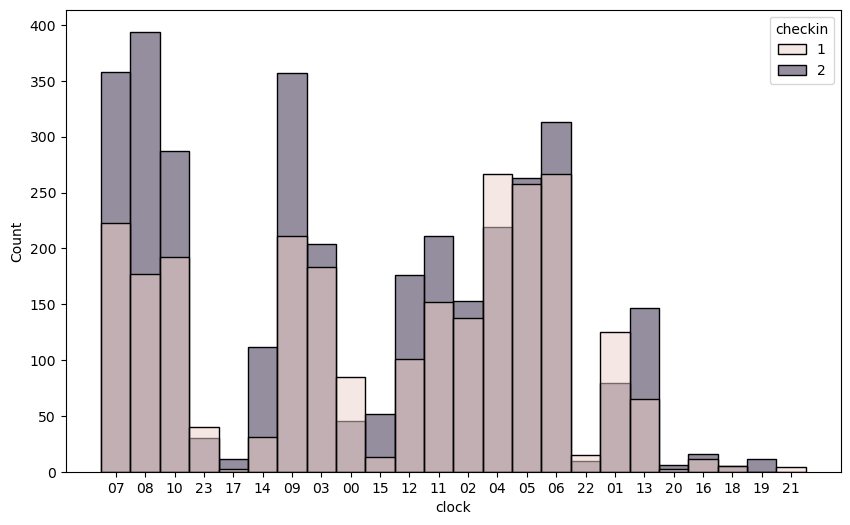

In [54]:
plt.figure(figsize=(10,6))
sns.histplot(data = first_access, x='clock',hue='checkin')

오전 8시로 첫번째 입장 시간으로 설정하자.

### first_enter_time 과 last_leave_time 둘 다 결측치인 데이터 처리

- 둘 다 없는 경우 가장 입장,퇴근 시간이 많은 시간으로 입장 시간을 대체해서 체류시간 더해 퇴장 시간 설정  
(이용 시간이 많은 09시와 13시로 나눠서 2 : 3의 비율로 나눠서 최초 출근 시간을 설정할 계획)

In [55]:

# 첫번째 입장 시각 칼럼을 생성하고 결측치를 채우기 위한 함수 정의
def fill_missing_times(row):
    if pd.isnull(row['first_enter_time']):
        times = np.random.choice(['09:00:00', '13:00:00'], p=[0.4, 0.6])  # 2:3 비율로 랜덤 선택
        return pd.to_datetime(str(row['date']) + ' ' + times)
    else:
        return row['first_enter_time']

trial_visit_info['first_enter_time'] = trial_visit_info.apply(fill_missing_times, axis=1)

trial_visit_info.head()


,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2,날짜
0,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182,2024-01-02
1,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012,2024-01-01
2,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656,2024-01-01
3,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848,2024-01-01
4,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430,2024-01-01


In [56]:
# # 결측값을 오전 8시로 채우기
# trial_visit_info['first_enter_time'] = trial_visit_info.apply(
#     lambda row: pd.to_datetime(f"{row['date']} 08:00:00") if pd.isnull(row['first_enter_time']) else row['first_enter_time'], axis=1
# )

# trial_visit_info

In [57]:
trial_visit_info[trial_visit_info['last_leave_time'].isna()]

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2,날짜
874,49,2023-11-05,2025-03-07 08:35:18.948111,30918,2023-11-05 13:00:00,NaT,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,0 days 08:35:18.948111,2023-11-05
876,49,2023-11-05,2025-03-07 08:58:26.565974,32306,2023-11-05 13:00:00,NaT,2ea2a495-5a75-4428-a976-ce420507d180,0 days 08:58:26.565974,2023-11-05
1158,3,2023-10-13,2025-03-07 06:49:46.262099,24586,2023-10-13 13:00:00,NaT,ba997800-e057-424e-b316-64db983aac50,0 days 06:49:46.262099,2023-10-13
2573,6,2023-06-22,2025-03-07 09:20:32.143216,33632,2023-06-22 09:00:00,NaT,1a057341-bf8c-4a17-b835-93cfa487bcd5,0 days 09:20:32.143216,2023-06-22
2596,1,2023-06-20,2025-03-07 23:57:38.418795,86258,2023-06-20 13:00:00,NaT,58fb08df-2803-437b-b2c7-29b1e03a119b,0 days 23:57:38.418795,2023-06-20
...,...,...,...,...,...,...,...,...,...
11461,3,2021-05-10,2025-03-07 03:48:11.631488,13691,2021-05-10 13:00:00,NaT,01cf3e09-9b2d-4d82-a50d-e6ccc03c33a2,0 days 03:48:11.631488,2021-05-10
11463,3,2021-05-09,2025-03-07 01:47:37.691566,6457,2021-05-09 09:00:00,NaT,409513f7-9c87-484f-b8d8-f17e71014e90,0 days 01:47:37.691566,2021-05-09
11464,3,2021-05-08,2025-03-07 02:13:19.762513,7999,2021-05-08 09:00:00,NaT,af90ff0b-d60b-4386-9c62-05c0e70cdf4a,0 days 02:13:19.762513,2021-05-08
11466,3,2021-05-07,2025-03-07 04:33:16.984740,16396,2021-05-07 13:00:00,NaT,2e1eed1c-e769-4c80-a4f9-1096e2170b39,0 days 04:33:16.984740,2021-05-07


In [58]:
# 최종퇴실시각 결측치 처리
# 결측값 채우기 (최초입실시각에서 체류시간을 더해서 최종퇴실시각을 계산)
trial_visit_info['last_leave_time'] = trial_visit_info.apply(
    lambda row: row['first_enter_time'] + row['stay_time2'] if pd.isnull(row['last_leave_time']) else row['last_leave_time'], axis=1
)

In [59]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   site_id           11477 non-null  int64          
 1   date              11477 non-null  datetime64[ns] 
 2   stay_time         11477 non-null  datetime64[ns] 
 3   stay_time_second  11477 non-null  int64          
 4   first_enter_time  11477 non-null  datetime64[ns] 
 5   last_leave_time   11477 non-null  datetime64[ns] 
 6   user_uuid         11477 non-null  object         
 7   stay_time2        11477 non-null  timedelta64[ns]
 8   날짜                11477 non-null  object         
dtypes: datetime64[ns](4), int64(2), object(2), timedelta64[ns](1)
memory usage: 807.1+ KB


In [60]:
trial_visit_info.drop(columns=['날짜'],axis=1,inplace=True)

In [61]:
trial_visit_info.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
0,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182
1,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012
2,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656
3,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848
4,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430


In [62]:
trial_visit_info2 = trial_visit_info.copy()

In [63]:
trial_visit_info2.to_csv("trial_visit_info2.csv")

## trial_access_log데이터 시각화 및 EDA

In [64]:
trial_access_log2

,checkin,cdate,site_id,user_uuid,year,month,day,time
0,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,07:11:55.201673
1,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:15:58.761284
2,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:10:41.848998
3,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,13:09:48.758097
4,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,10:12:42.083352
...,...,...,...,...,...,...,...,...
63703,2,2023-04-26 09:04:44.770319,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,09:04:44.770319
63704,1,2023-04-26 06:09:14.228682,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,06:09:14.228682
63705,1,2023-11-04 11:50:10.657353,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,11:50:10.657353
63706,2,2023-11-04 13:31:41.599473,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,13:31:41.599473


In [65]:
trial_access_log2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   checkin    63708 non-null  int64         
 1   cdate      63708 non-null  datetime64[ns]
 2   site_id    63708 non-null  int64         
 3   user_uuid  63708 non-null  object        
 4   year       63708 non-null  int32         
 5   month      63708 non-null  int32         
 6   day        63708 non-null  int32         
 7   time       63708 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(2), object(2)
memory usage: 3.2+ MB


In [66]:
trial_access_log2['hour'] = trial_access_log2['cdate'].dt.hour

In [67]:
trial_access_log2

,checkin,cdate,site_id,user_uuid,year,month,day,time,hour
0,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,07:11:55.201673,7
1,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,15:15:58.761284,15
2,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,14:10:41.848998,14
3,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,6,13:09:48.758097,13
4,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89,2023,7,7,10:12:42.083352,10
...,...,...,...,...,...,...,...,...,...
63703,2,2023-04-26 09:04:44.770319,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,09:04:44.770319,9
63704,1,2023-04-26 06:09:14.228682,49,8b271f57-2ce2-4b32-80b8-0fabb98390a7,2023,4,26,06:09:14.228682,6
63705,1,2023-11-04 11:50:10.657353,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,11:50:10.657353,11
63706,2,2023-11-04 13:31:41.599473,49,c02b96c8-bcba-4f8c-baf8-99f6c35076f4,2023,11,4,13:31:41.599473,13


In [68]:
trial_access_log2.duplicated().sum()

359

시간 대 별 이동량 그래프

<Axes: xlabel='hour', ylabel='Count'>

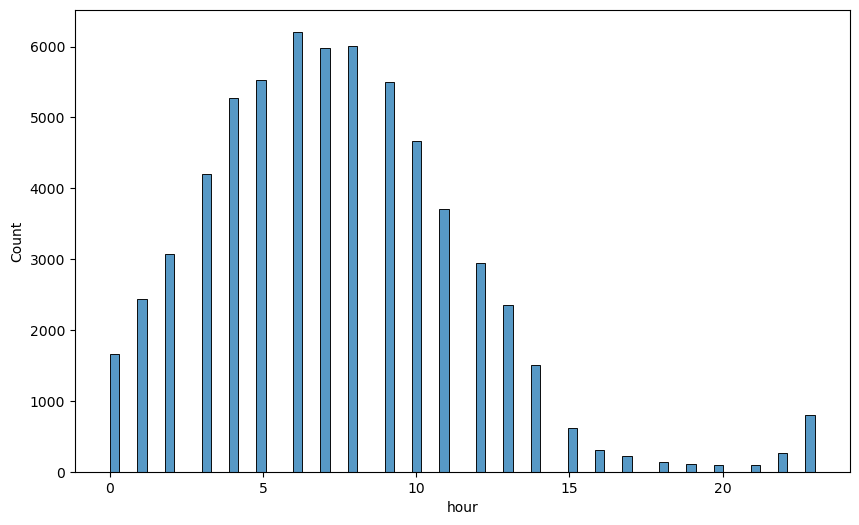

In [69]:
plt.figure(figsize=(10,6))
sns.histplot(data=trial_access_log2, x='hour')

월 별 이용량 분석

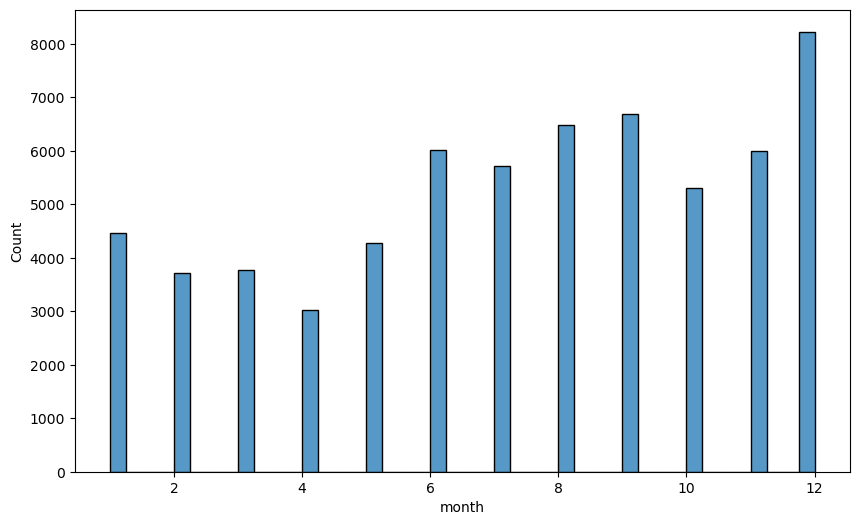

In [70]:
plt.figure(figsize=(10,6))
sns.histplot(data=trial_access_log2, x='month')
plt.show()

In [71]:
trial_access_log2['site_id'] = trial_access_log2['site_id'].astype('object')

In [72]:
trial_access_log2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   checkin    63708 non-null  int64         
 1   cdate      63708 non-null  datetime64[ns]
 2   site_id    63708 non-null  object        
 3   user_uuid  63708 non-null  object        
 4   year       63708 non-null  int32         
 5   month      63708 non-null  int32         
 6   day        63708 non-null  int32         
 7   time       63708 non-null  object        
 8   hour       63708 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(1), object(3)
memory usage: 3.4+ MB


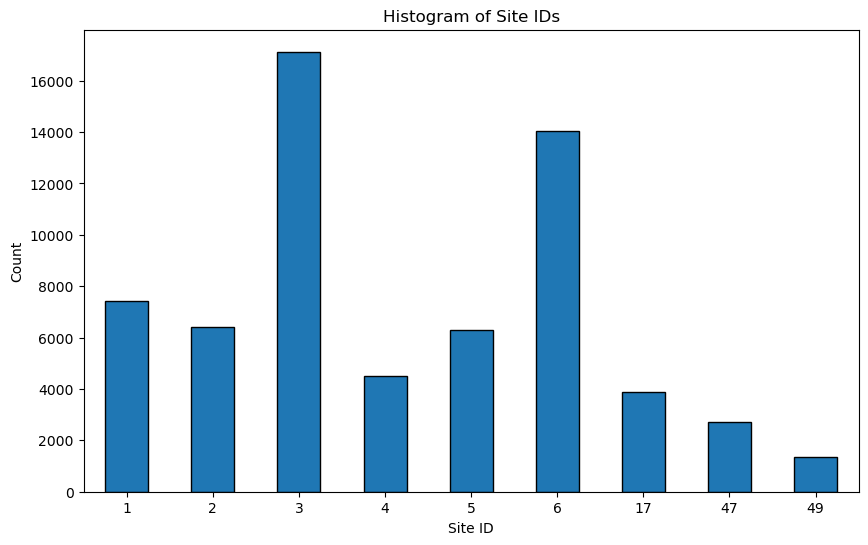

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
trial_access_log2['site_id'].value_counts().sort_index().plot(kind='bar', edgecolor='k')
plt.xlabel('Site ID')
plt.ylabel('Count')
plt.title('Histogram of Site IDs')
plt.xticks(rotation = 0)
plt.show()



In [74]:
trial_access_log2['day_of_week'] = trial_access_log2['cdate'].dt.day_of_week

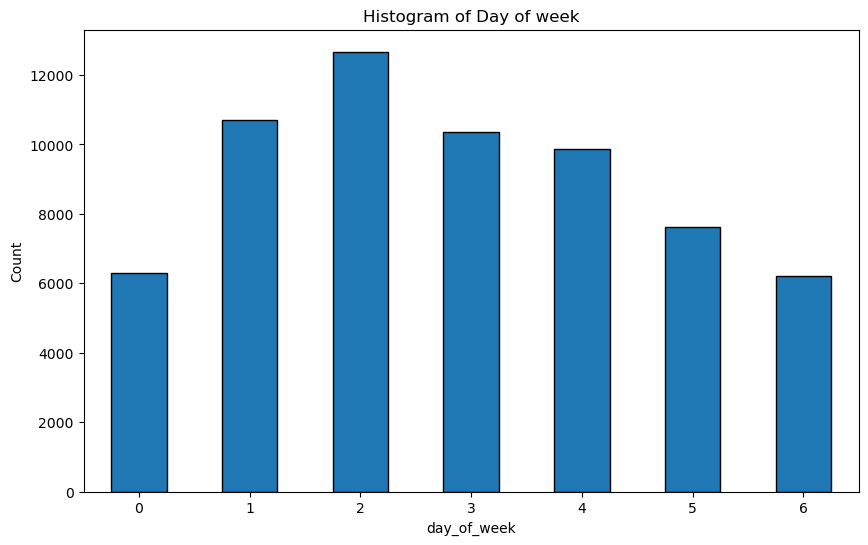

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
trial_access_log2['day_of_week'].value_counts().sort_index().plot(kind='bar', edgecolor='k')
plt.xlabel('day_of_week')
plt.ylabel('Count')
plt.title('Histogram of Day of week')
plt.xticks(rotation = 0)
plt.show()

# 머신 러닝 모델

랜덤 포레스트 및 xgboost 그리고 catboost등을 통해서 분류 모델 정확도 예측  

종속 변수 : is_payment

## Random Forest 모델 

In [76]:
share_office_data = pd.read_csv('share_office_data.csv', index_col=False)

In [77]:
share_office_data

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0,weekend_0,weekend_1,weekend_2
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,False,False,False,False,False,True,False,True,False
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,False,False,False,False,False,False,False,True,False
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,False,False,False,True,False,False,False,True,False
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,2,2.383776,1.617236,False,False,False,False,False,True,False,False,False,False,False,True
9620,9620,0,43263092-3b28-4817-9fa9-4205ad3097fe,2023-11-17,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False
9621,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,False,False,True,False,False,False,False,False,True
9622,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1,-0.461448,-0.081284,False,False,True,False,False,False,False,False,False,False,False,True


### 히트맵

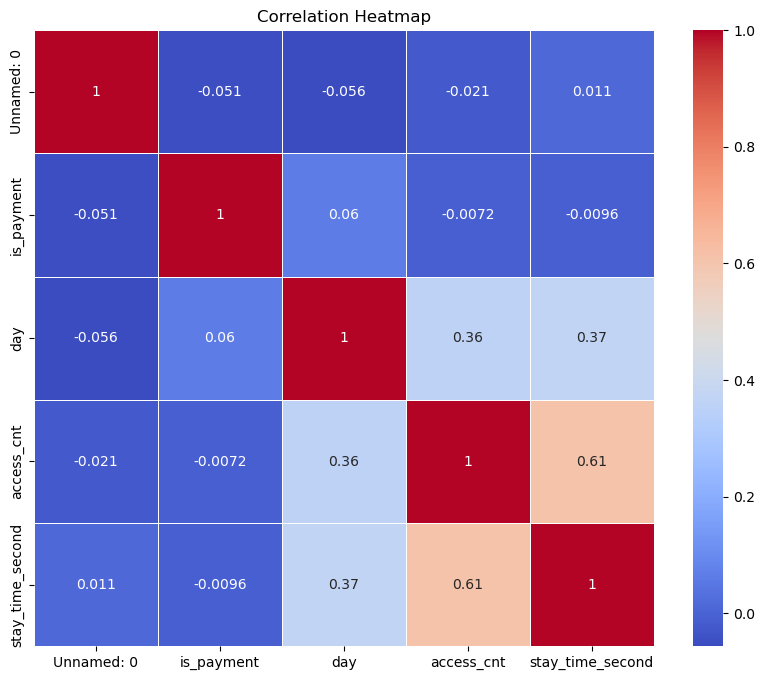

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 행렬 계산
correlation_matrix = share_office_data.select_dtypes(include=['int','float']).corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [79]:
share_office_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        9624 non-null   int64  
 1   is_payment        9624 non-null   int64  
 2   user_uuid         9624 non-null   object 
 3   trial_date        9624 non-null   object 
 4   day               9624 non-null   int64  
 5   access_cnt        9624 non-null   float64
 6   stay_time_second  9624 non-null   float64
 7   site_id_1.0       9624 non-null   bool   
 8   site_id_2.0       9624 non-null   bool   
 9   site_id_3.0       9624 non-null   bool   
 10  site_id_4.0       9624 non-null   bool   
 11  site_id_5.0       9624 non-null   bool   
 12  site_id_6.0       9624 non-null   bool   
 13  site_id_17.0      9624 non-null   bool   
 14  site_id_47.0      9624 non-null   bool   
 15  site_id_49.0      9624 non-null   bool   
 16  weekend_0         9624 non-null   bool   


In [80]:
share = share_office_data.copy()

In [81]:
share

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0,weekend_0,weekend_1,weekend_2
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,False,False,False,False,False,True,False,True,False
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,False,False,False,False,False,False,False,True,False
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,False,False,False,True,False,False,False,True,False
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,2,2.383776,1.617236,False,False,False,False,False,True,False,False,False,False,False,True
9620,9620,0,43263092-3b28-4817-9fa9-4205ad3097fe,2023-11-17,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False
9621,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,False,False,True,False,False,False,False,False,True
9622,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1,-0.461448,-0.081284,False,False,True,False,False,False,False,False,False,False,False,True


In [82]:
share['day'].value_counts()

day
1    3804
0    3087
2    2239
3     484
4      10
Name: count, dtype: int64

In [83]:
share['trial_date'] = pd.to_datetime(share['trial_date'])
share['month'] = share['trial_date'].dt.month

In [84]:
share

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0,weekend_0,weekend_1,weekend_2,month
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,False,False,False,False,False,True,False,True,False,12
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,False,False,False,False,False,False,False,True,False,12
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,12
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,False,False,False,True,False,False,False,True,False,12
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,False,False,False,True,False,False,False,True,False,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,2,2.383776,1.617236,False,False,False,False,False,True,False,False,False,False,False,True,11
9620,9620,0,43263092-3b28-4817-9fa9-4205ad3097fe,2023-11-17,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,11
9621,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,False,False,True,False,False,False,False,False,True,11
9622,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1,-0.461448,-0.081284,False,False,True,False,False,False,False,False,False,False,False,True,11


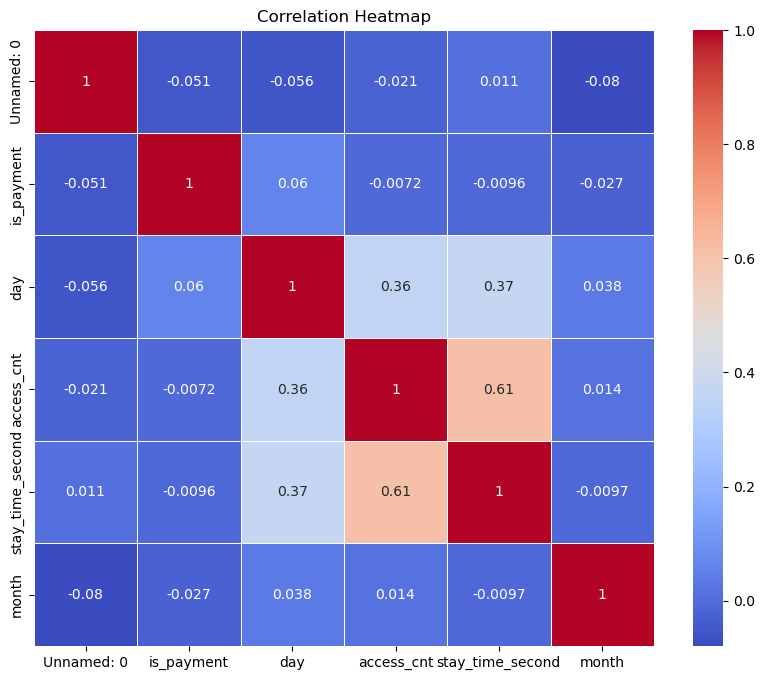

In [85]:

# 상관관계 행렬 계산
correlation_matrix = share.select_dtypes(include=['int','float']).corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [86]:
share_office_data.drop(columns=['user_uuid'],inplace=True)

In [87]:
share_office_data.drop(columns=['trial_date'],inplace=True)

In [88]:
share_office_data.drop(columns=['Unnamed: 0'],inplace=True)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

In [90]:
X = share_office_data.drop(columns=['is_payment'])
y = share_office_data['is_payment']

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=45)

In [92]:
# 랜덤 포레스트 모델 생성 (결정 트리 100개, 최대 깊이 4), random_state는 항상 같은 결과 나오도록!
model = RandomForestClassifier(n_estimators=100, random_state=45)

# 모델 학습
### ravel()은 에러가 날 때마다 언제든 해준다는 식으로 - 외우지 말고!
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=45)

In [93]:
y_pred = model.predict(X_valid)

In [94]:
# 모델 성능 평가 (정확도)
score = model.score(X_valid, y_valid) # model.score는 입력에 y_pred가 아니라 X_test를 넣어준다. (예측은 포함)
print(f"모델 정확도: {score:.2f}")

모델 정확도: 0.57


## catboost 모델 

In [95]:
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

# 불균형 데이터셋 생성 (예시)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1], random_state=42)
print(f"Original dataset shape: {Counter(y)}")

# SMOTE 적용
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {Counter(y_res)}")


Original dataset shape: Counter({0: 897, 1: 103})
Resampled dataset shape: Counter({0: 4803, 1: 4803})


In [96]:
from imblearn.combine import SMOTETomek

In [97]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# CatBoost Pool 생성
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# CatBoostClassifier 모델 초기화 및 학습
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=100)
model.fit(train_pool)

# 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


0:	learn: 0.6913254	total: 169ms	remaining: 2m 48s
100:	learn: 0.6417839	total: 677ms	remaining: 6.03s
200:	learn: 0.6000713	total: 1.22s	remaining: 4.85s
300:	learn: 0.5766747	total: 1.81s	remaining: 4.21s
400:	learn: 0.5577707	total: 2.47s	remaining: 3.68s
500:	learn: 0.5425605	total: 3.07s	remaining: 3.06s
600:	learn: 0.5291047	total: 3.79s	remaining: 2.52s
700:	learn: 0.5172836	total: 4.51s	remaining: 1.93s
800:	learn: 0.5074850	total: 5.25s	remaining: 1.3s
900:	learn: 0.4980535	total: 5.98s	remaining: 657ms
999:	learn: 0.4897041	total: 6.67s	remaining: 0us
Accuracy: 0.609261186264308


In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       982
           1       0.65      0.44      0.52       940

    accuracy                           0.61      1922
   macro avg       0.62      0.61      0.60      1922
weighted avg       0.62      0.61      0.60      1922



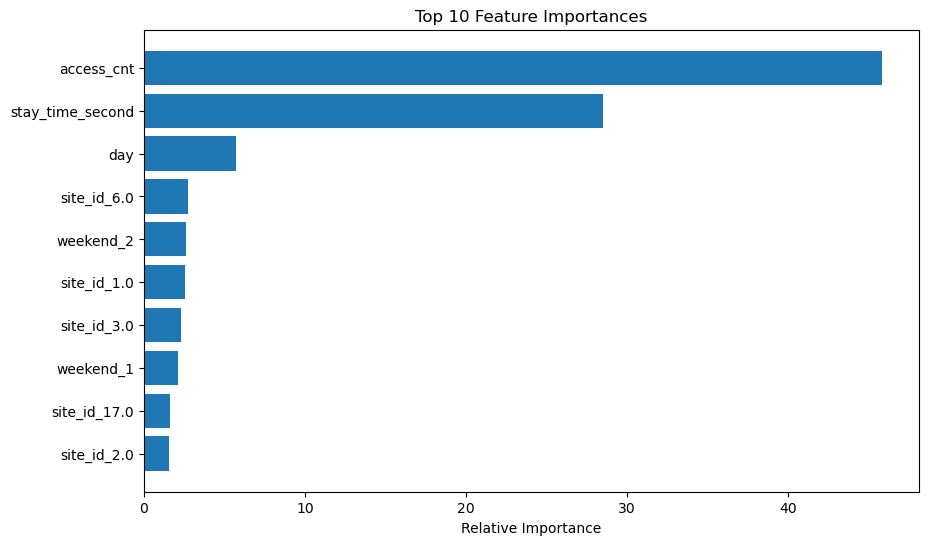

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 피처 중요도 추출
importances = model.feature_importances_

# 피처 이름 정의
feature_names = pd.DataFrame(X_train, columns=share_office_data.drop(columns=['is_payment']).columns).columns

# 피처 중요도 정렬 후 상위 10개 선택
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Xgboost 모델

In [100]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# DMatrix 생성
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# XGBoost 모델 초기화 및 학습
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'logloss'
}
num_round = 100

bst = xgb.train(params, train_dmatrix, num_round)

# 예측
y_pred = bst.predict(test_dmatrix)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5842872008324662


In [101]:
share.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0,weekend_0,weekend_1,weekend_2,month
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,False,False,False,False,False,True,False,True,False,12
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,False,False,False,False,False,False,False,True,False,12
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,12
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,False,False,False,True,False,False,False,True,False,12
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,False,False,False,True,False,False,False,True,False,12


In [102]:
trial_visit_info2.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
0,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182
1,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012
2,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656
3,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848
4,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430


### share_office_data에 첫 입장 시간과 마지막 나가는 시간 칼럼 추가

In [103]:
trial_visit = trial_visit_info2[['user_uuid','first_enter_time','last_leave_time','stay_time2']]

In [104]:
share_df = pd.merge(share,trial_visit,on='user_uuid',how='inner')

In [105]:
share_df.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,site_id_17.0,site_id_47.0,site_id_49.0,weekend_0,weekend_1,weekend_2,month,first_enter_time,last_leave_time,stay_time2
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,False,False,True,False,True,False,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,False,False,False,False,True,False,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,True,False,False,False,True,False,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,True,False,False,False,True,False,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,False,False,False,False,True,False,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670


In [106]:
share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Unnamed: 0        11477 non-null  int64          
 1   is_payment        11477 non-null  int64          
 2   user_uuid         11477 non-null  object         
 3   trial_date        11477 non-null  datetime64[ns] 
 4   day               11477 non-null  int64          
 5   access_cnt        11477 non-null  float64        
 6   stay_time_second  11477 non-null  float64        
 7   site_id_1.0       11477 non-null  bool           
 8   site_id_2.0       11477 non-null  bool           
 9   site_id_3.0       11477 non-null  bool           
 10  site_id_4.0       11477 non-null  bool           
 11  site_id_5.0       11477 non-null  bool           
 12  site_id_6.0       11477 non-null  bool           
 13  site_id_17.0      11477 non-null  bool           
 14  site_i

### 첫 입장 시간 칼럼과 마지막 시간 칼럼 추가

In [107]:
share_df['first_hour'] = share_df['first_enter_time'].dt.hour
share_df['leave_hour'] = share_df['last_leave_time'].dt.hour

In [108]:
share_df.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,site_id_49.0,weekend_0,weekend_1,weekend_2,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,True,False,True,False,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,False,False,True,False,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,False,False,True,False,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,False,False,True,False,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,False,False,True,False,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17


In [109]:
share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Unnamed: 0        11477 non-null  int64          
 1   is_payment        11477 non-null  int64          
 2   user_uuid         11477 non-null  object         
 3   trial_date        11477 non-null  datetime64[ns] 
 4   day               11477 non-null  int64          
 5   access_cnt        11477 non-null  float64        
 6   stay_time_second  11477 non-null  float64        
 7   site_id_1.0       11477 non-null  bool           
 8   site_id_2.0       11477 non-null  bool           
 9   site_id_3.0       11477 non-null  bool           
 10  site_id_4.0       11477 non-null  bool           
 11  site_id_5.0       11477 non-null  bool           
 12  site_id_6.0       11477 non-null  bool           
 13  site_id_17.0      11477 non-null  bool           
 14  site_i

### 시간대 추가 (0~3)은 새벽~야간 순서

In [110]:
def 시간대_분류(시간):
    # 시간 값이 정수라면 문자열로 변환
    if isinstance(시간, int):
        시간 = f"{시간:02}:00"  # 예: 8 → "08:00" 형태로 변환
    # 문자열이므로 split 적용 가능
    hour = int(시간.split(':')[0])
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    else:
        return 3

# 예제 적용
share_df['time_zone'] = share_df['first_hour'].apply(시간대_분류)


In [111]:
share_df.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,weekend_0,weekend_1,weekend_2,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour,time_zone
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,False,True,False,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16,1
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,False,True,False,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15,0
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,False,True,False,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22,3
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,False,True,False,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22,3
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,False,True,False,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17,2


### day_of_week 칼럼 추가

In [112]:
share_df['day_of_week'] = share_df['first_enter_time'].dt.day_of_week

In [113]:
share_df.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,weekend_1,weekend_2,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour,time_zone,day_of_week
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,True,False,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16,1,3
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,True,False,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15,0,3
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,True,False,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22,3,3
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,True,False,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22,3,3
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,True,False,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17,2,4


In [114]:
site_area

,site_id,area_pyeong
0,1,50
1,2,100
2,3,150
3,4,100
4,5,150
5,6,150
6,17,50
7,47,50
8,49,50


### site_id 칼럼 추가

In [115]:
weekday_merged = pd.read_csv('weekday_merged.csv')

In [116]:
weekday_merged.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id,weekend
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1.0,12.0,19596.0,49.0,0.0
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2.0,4.0,11084.0,2.0,0.0
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,NaN,NaN,NaN,NaN,NaN
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1.0,3.0,4775.0,17.0,0.0
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1.0,5.0,5037.0,17.0,0.0


In [117]:
site = weekday_merged[['user_uuid','site_id']]

In [118]:
share_df = pd.merge(share_df,site,on='user_uuid',how='inner')

In [119]:
share_df

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,weekend_2,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour,time_zone,day_of_week,site_id
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,False,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16,1,3,49.0
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,False,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15,0,3,2.0
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,False,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22,3,3,17.0
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,False,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22,3,3,17.0
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,False,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17,2,4,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11472,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,...,True,11,2023-11-19 11:18:32.407466,2023-11-19 20:23:57.657447,0 days 08:56:44.761698,11,20,1,6,6.0
11473,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,...,True,11,2023-11-18 12:16:34.353406,2023-11-18 19:32:32.927280,0 days 07:11:00.528259,12,19,2,5,6.0
11474,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1,-0.461448,-0.081284,False,False,True,...,True,11,2023-11-19 13:29:00.833677,2023-11-19 21:57:56.623158,0 days 07:32:08.840689,13,21,2,6,3.0
11475,9623,0,b7633cc2-bde9-4dff-9c8f-33dac3c976c2,2023-11-18,2,0.851732,1.037939,False,False,False,...,True,11,2023-11-20 13:40:30.269165,2023-11-20 20:02:06.251726,0 days 06:19:18.172657,13,20,2,0,6.0


In [120]:
share_df['time_zone'].value_counts()

time_zone
2    5531
1    3390
3    1694
0     862
Name: count, dtype: int64

In [121]:
share_df = pd.merge(share_df, site_area,on='site_id',how='inner')

In [122]:
share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Unnamed: 0        11477 non-null  int64          
 1   is_payment        11477 non-null  int64          
 2   user_uuid         11477 non-null  object         
 3   trial_date        11477 non-null  datetime64[ns] 
 4   day               11477 non-null  int64          
 5   access_cnt        11477 non-null  float64        
 6   stay_time_second  11477 non-null  float64        
 7   site_id_1.0       11477 non-null  bool           
 8   site_id_2.0       11477 non-null  bool           
 9   site_id_3.0       11477 non-null  bool           
 10  site_id_4.0       11477 non-null  bool           
 11  site_id_5.0       11477 non-null  bool           
 12  site_id_6.0       11477 non-null  bool           
 13  site_id_17.0      11477 non-null  bool           
 14  site_i

In [123]:
share_df.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour,time_zone,day_of_week,site_id,area_pyeong
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16,1,3,49.0,50
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15,0,3,2.0,100
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22,3,3,17.0,50
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22,3,3,17.0,50
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17,2,4,6.0,150


In [124]:
share_df.columns

Index(['Unnamed: 0', 'is_payment', 'user_uuid', 'trial_date', 'day',
       'access_cnt', 'stay_time_second', 'site_id_1.0', 'site_id_2.0',
       'site_id_3.0', 'site_id_4.0', 'site_id_5.0', 'site_id_6.0',
       'site_id_17.0', 'site_id_47.0', 'site_id_49.0', 'weekend_0',
       'weekend_1', 'weekend_2', 'month', 'first_enter_time',
       'last_leave_time', 'stay_time2', 'first_hour', 'leave_hour',
       'time_zone', 'day_of_week', 'site_id', 'area_pyeong'],
      dtype='object')

In [125]:
share_df = share_df.drop_duplicates(subset=['user_uuid','trial_date'])

In [126]:
share_df

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,...,month,first_enter_time,last_leave_time,stay_time2,first_hour,leave_hour,time_zone,day_of_week,site_id,area_pyeong
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1,0.195142,-0.376638,False,False,False,...,12,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0 days 05:26:36.406421,9,16,1,3,49.0,50
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2,-0.680311,-0.710421,False,True,False,...,12,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0 days 03:04:44.451817,4,15,0,3,2.0,100
2,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1,-0.789743,-0.957817,False,False,False,...,12,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0 days 01:19:35.471319,21,22,3,3,17.0,50
3,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1,-0.570880,-0.947543,False,False,False,...,12,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0 days 01:23:57.598777,21,22,3,3,17.0,50
4,6,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22,1,-0.680311,-0.815826,False,False,False,...,12,2023-12-22 15:37:55.074825,2023-12-22 17:59:12.618339,0 days 02:19:56.340670,15,17,2,4,6.0,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11467,9617,0,fab9965a-9bbe-470b-8163-3ce6352baeca,2023-11-17,2,1.727186,0.075569,False,False,False,...,11,2023-11-19 13:32:16.920831,2023-11-19 16:53:41.811313,0 days 03:18:53.963787,13,16,2,6,4.0,100
11469,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,2,2.383776,1.617236,False,False,False,...,11,2023-11-19 10:11:41.755353,2023-11-19 19:06:23.155536,0 days 08:26:08.548117,10,19,1,6,6.0,150
11471,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2,0.304574,2.304369,False,False,False,...,11,2023-11-20 11:00:09.615256,2023-11-20 19:37:41.573844,0 days 08:18:22.166195,11,19,1,0,6.0,150
11474,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1,-0.461448,-0.081284,False,False,True,...,11,2023-11-19 13:29:00.833677,2023-11-19 21:57:56.623158,0 days 07:32:08.840689,13,21,2,6,3.0,150


In [127]:
share_model = share_df.drop(columns=['Unnamed: 0','trial_date','first_enter_time','last_leave_time','site_id'])

## 모델 돌려보기

In [128]:
share_model

,is_payment,user_uuid,day,access_cnt,stay_time_second,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,...,weekend_0,weekend_1,weekend_2,month,stay_time2,first_hour,leave_hour,time_zone,day_of_week,area_pyeong
0,0,2b251333-8676-4c11-a736-dcf2350f8821,1,0.195142,-0.376638,False,False,False,False,False,...,False,True,False,12,0 days 05:26:36.406421,9,16,1,3,50
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2,-0.680311,-0.710421,False,True,False,False,False,...,False,True,False,12,0 days 03:04:44.451817,4,15,0,3,100
2,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,1,-0.789743,-0.957817,False,False,False,False,False,...,False,True,False,12,0 days 01:19:35.471319,21,22,3,3,50
3,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,1,-0.570880,-0.947543,False,False,False,False,False,...,False,True,False,12,0 days 01:23:57.598777,21,22,3,3,50
4,0,b2d80cf6-2ced-4270-9d7a-43119bba35d2,1,-0.680311,-0.815826,False,False,False,False,False,...,False,True,False,12,0 days 02:19:56.340670,15,17,2,4,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11467,0,fab9965a-9bbe-470b-8163-3ce6352baeca,2,1.727186,0.075569,False,False,False,True,False,...,False,False,True,11,0 days 03:18:53.963787,13,16,2,6,100
11469,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2,2.383776,1.617236,False,False,False,False,False,...,False,False,True,11,0 days 08:26:08.548117,10,19,1,6,150
11471,0,51a40f33-1027-4544-9b95-45bca7c104fb,2,0.304574,2.304369,False,False,False,False,False,...,False,False,True,11,0 days 08:18:22.166195,11,19,1,0,150
11474,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,1,-0.461448,-0.081284,False,False,True,False,False,...,False,False,True,11,0 days 07:32:08.840689,13,21,2,6,150


In [129]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [130]:
# SMOTE 적용하기 ###### 얘가 젤 낫다
from imblearn.over_sampling import SMOTE

# 독립변수 종속변수 분리하기 
x = share_model.drop(['is_payment','user_uuid','stay_time2'], axis = 1)
y = share_model['is_payment']

# SMOTE 적용 (소수 클래스 오버샘플링)
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# 학습/테스트 데이터 분할 (8:2 비율)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(x_resampled, y_resampled)

# 예측 및 평가
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7814861460957179
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       827
           1       0.83      0.68      0.75       761

    accuracy                           0.78      1588
   macro avg       0.79      0.78      0.78      1588
weighted avg       0.79      0.78      0.78      1588



In [131]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np

# Stratified K-Fold 설정 (5-Fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost 모델 & 하이퍼파라미터 그리드 설정
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0]
}

# Pipeline 생성 (SMOTE + XGBoost)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # 훈련 데이터에만 SMOTE 적용
    ('xgbclassifier', XGBClassifier(random_state=42))
])

# GridSearchCV 적용
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kf,
    verbose=2,
    n_jobs=-1
)

# 데이터 분할 (SMOTE 적용 전, 원본 데이터로 진행)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# GridSearch 실행
grid_search.fit(x_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Accuracy: 0.6273909716908952
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       794
           1       0.54      0.38      0.45       513

    accuracy                           0.63      1307
   macro avg       0.60      0.58      0.58      1307
weighted avg       0.61      0.63      0.61      1307



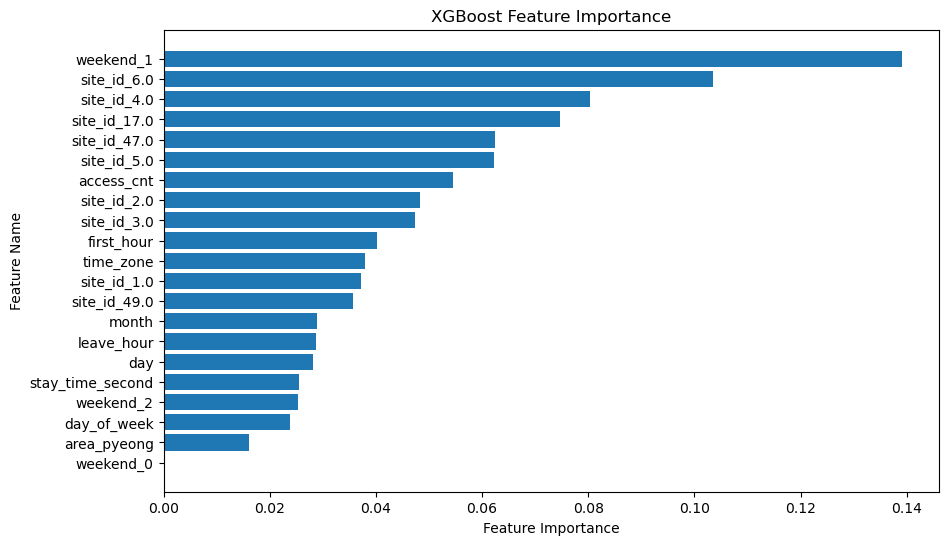

In [132]:
# Feature Importance 추출
feature_importances = model.feature_importances_
feature_names = x.columns

# 데이터프레임 생성 후 정렬
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 정렬
plt.show()

In [133]:
share_model.to_csv('share_data.csv')

In [134]:
share_df.groupby('site_id')[['is_payment']].mean()

,is_payment
site_id,
1.0,0.423673
2.0,0.359561
3.0,0.425564
4.0,0.405242
5.0,0.449495
6.0,0.354082
17.0,0.352246
47.0,0.338509
49.0,0.429630


지점 별로 결제 비율이 차이가 있다.

## 이용량 예측

In [135]:
weekday_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        9624 non-null   int64  
 1   is_payment        9624 non-null   int64  
 2   user_uuid         9624 non-null   object 
 3   trial_date        9624 non-null   object 
 4   day               6537 non-null   float64
 5   access_cnt        6537 non-null   float64
 6   stay_time_second  6537 non-null   float64
 7   site_id           6534 non-null   float64
 8   weekend           6537 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 676.8+ KB


In [136]:
weekday_merged['trial_date'] = pd.to_datetime(weekday_merged['trial_date'])

In [137]:
weekday_merged['day_of_week'] = weekday_merged['trial_date'].dt.day_of_week

In [138]:
weekday_merged['month'] = weekday_merged['trial_date'].dt.month

In [139]:
weekday_merged

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,site_id,weekend,day_of_week,month
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,1.0,12.0,19596.0,49.0,0.0,3,12
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,2.0,4.0,11084.0,2.0,0.0,3,12
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,NaN,NaN,NaN,NaN,NaN,3,12
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,1.0,3.0,4775.0,17.0,0.0,3,12
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,1.0,5.0,5037.0,17.0,0.0,3,12
...,...,...,...,...,...,...,...,...,...,...,...
9619,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,2.0,32.0,70443.0,6.0,1.0,4,11
9620,9620,0,43263092-3b28-4817-9fa9-4205ad3097fe,2023-11-17,NaN,NaN,NaN,NaN,NaN,4,11
9621,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,2.0,13.0,87966.0,6.0,1.0,4,11
9622,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,1.0,6.0,27128.0,3.0,1.0,5,11


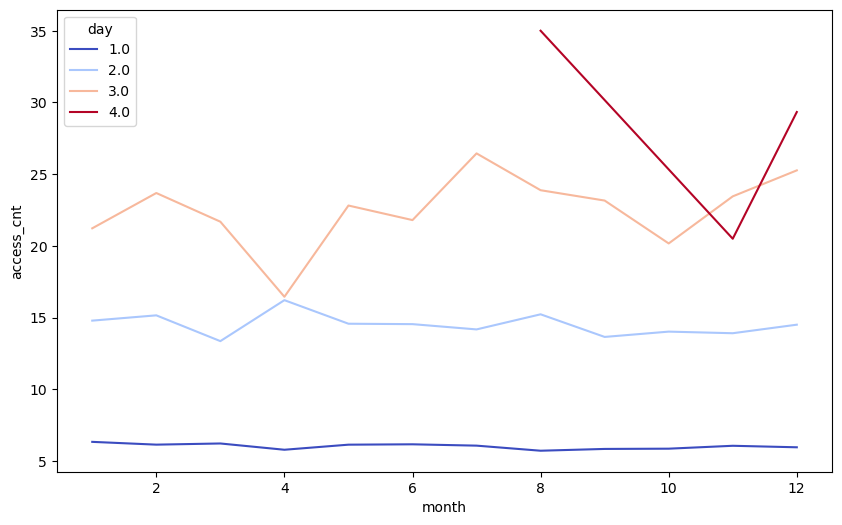

In [140]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = weekday_merged,x='month',y='access_cnt',hue='day',errorbar=None,palette='coolwarm')
plt.show()

In [141]:
weekday_merged.groupby('day')[['is_payment']].mean()

,is_payment
day,
1.0,0.368034
2.0,0.421170
3.0,0.450413
4.0,0.300000


C:\Users\seonw\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\seonw\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\seonw\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\seonw\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\seonw\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55

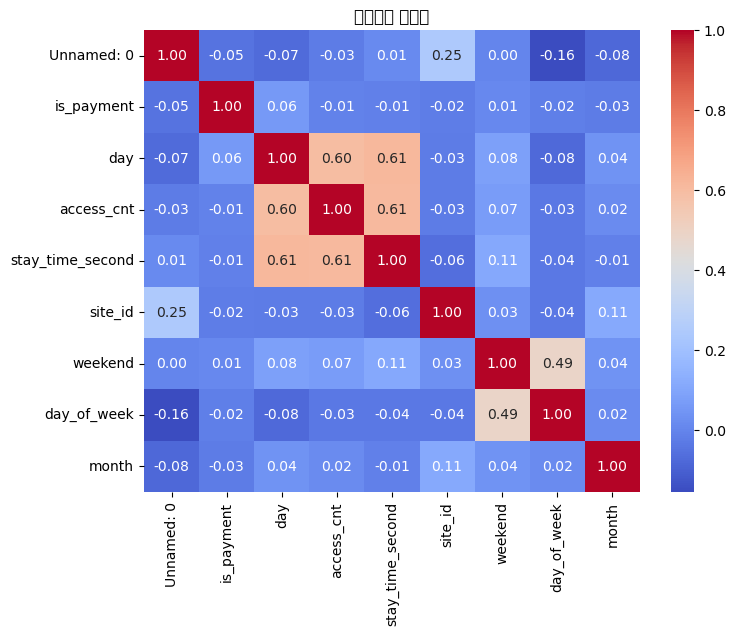

In [142]:

# 상관계수 계산
correlation_matrix = weekday_merged.select_dtypes(include=['int','float']).corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관계수 히트맵")
plt.show()


In [143]:
weekday_merged.describe()

,Unnamed: 0,is_payment,trial_date,day,access_cnt,stay_time_second,site_id,weekend,day_of_week,month
count,9624.000000,9624.000000,9624,6537.000000,6537.000000,6537.000000,6534.000000,6537.000000,9624.000000,9624.000000
mean,4811.500000,0.379468,2022-08-08 21:36:48.478802944,1.495181,10.216766,29200.874101,7.406795,0.302891,2.413446,7.114401
min,0.000000,0.000000,2021-05-01 00:00:00,1.000000,1.000000,9.000000,1.000000,0.000000,0.000000,1.000000
25%,2405.750000,0.000000,2021-11-25 00:00:00,1.000000,4.000000,10466.000000,2.000000,0.000000,1.000000,5.000000
50%,4811.500000,0.000000,2022-08-02 00:00:00,1.000000,8.000000,21712.000000,3.000000,0.000000,2.000000,8.000000
75%,7217.250000,1.000000,2023-04-11 00:00:00,2.000000,14.000000,40863.000000,6.000000,1.000000,4.000000,10.000000
max,9623.000000,1.000000,2023-12-31 00:00:00,4.000000,126.000000,249203.000000,49.000000,1.000000,6.000000,12.000000
std,2778.353829,0.485280,NaN,0.638199,9.138820,25503.565018,11.630996,0.459544,1.895150,3.359277


## 한번 더 EDA

## is_payment 분류 모델 해보기

In [144]:
trial_visit_info2.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,stay_time2
0,3,2024-01-02,2025-03-07 00:40:41.437182,2441,2024-01-02 19:37:50.345305,2024-01-02 20:20:08.337566,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 00:40:41.437182
1,49,2024-01-01,2025-03-07 01:53:53.690012,6833,2024-01-01 14:01:18.626838,2024-01-01 15:58:02.826332,2d420a09-9889-412a-a06a-5c31c9989572,0 days 01:53:53.690012
2,3,2024-01-01,2025-03-07 04:47:05.102656,17225,2024-01-01 12:05:05.841506,2024-01-01 21:37:40.489976,418edd26-c1c1-49f6-b67f-3b29c3e868e9,0 days 04:47:05.102656
3,4,2024-01-01,2025-03-07 03:59:20.004848,14360,2024-01-01 14:30:55.279667,2024-01-01 18:33:02.104582,e9b1a5df-d70c-4ccf-af22-64fdae98d3a2,0 days 03:59:20.004848
4,4,2024-01-01,2025-03-07 00:55:41.445430,3341,2024-01-01 17:39:42.078159,2024-01-01 18:38:05.414576,e80f7f66-f24a-4637-95c9-20288fd811ee,0 days 00:55:41.445430


In [145]:
trial_visit_info2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   site_id           11477 non-null  int64          
 1   date              11477 non-null  datetime64[ns] 
 2   stay_time         11477 non-null  datetime64[ns] 
 3   stay_time_second  11477 non-null  int64          
 4   first_enter_time  11477 non-null  datetime64[ns] 
 5   last_leave_time   11477 non-null  datetime64[ns] 
 6   user_uuid         11477 non-null  object         
 7   stay_time2        11477 non-null  timedelta64[ns]
dtypes: datetime64[ns](4), int64(2), object(1), timedelta64[ns](1)
memory usage: 717.4+ KB


In [146]:
share_data = pd.read_csv('share_office_data3.csv')

In [147]:
share_data.head()

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,dayofweek_0,dayofweek_1,dayofweek_2,...,office_area_150.0,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,-0.775964,0.195142,-0.376638,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,0.791066,-0.680311,-0.710421,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,-0.775964,-0.789743,-0.957817,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,-0.775964,-0.570880,-0.947543,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [148]:
share_data.columns

Index(['Unnamed: 0', 'is_payment', 'user_uuid', 'trial_date', 'day',
       'access_cnt', 'stay_time_second', 'dayofweek_0', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'weekend_0', 'weekend_1', 'weekend_2',
       'office_area_50.0', 'office_area_100.0', 'office_area_150.0',
       'site_id_1.0', 'site_id_2.0', 'site_id_3.0', 'site_id_4.0',
       'site_id_5.0', 'site_id_6.0', 'site_id_17.0', 'site_id_47.0',
       'site_id_49.0'],
      dtype='object')

In [149]:
share_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         9624 non-null   int64  
 1   is_payment         9624 non-null   int64  
 2   user_uuid          9624 non-null   object 
 3   trial_date         9624 non-null   object 
 4   day                9624 non-null   float64
 5   access_cnt         9624 non-null   float64
 6   stay_time_second   9624 non-null   float64
 7   dayofweek_0        6537 non-null   float64
 8   dayofweek_1        6537 non-null   float64
 9   dayofweek_2        6537 non-null   float64
 10  dayofweek_3        6537 non-null   float64
 11  dayofweek_4        6537 non-null   float64
 12  dayofweek_5        6537 non-null   float64
 13  dayofweek_6        6537 non-null   float64
 14  weekend_0          9624 non-null   int64  
 15  weekend_1          9624 non-null   int64  
 16  weekend_2          9624 

In [150]:
x = share_data.drop(['Unnamed: 0','is_payment','user_uuid', 'trial_date'], axis = 1)
y = share_data['is_payment']

In [151]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import numpy as np

# Stratified K-Fold 설정 (5-Fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost 모델 & 하이퍼파라미터 그리드 설정
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0]
}

# Pipeline 생성 (Imputer + SMOTE + XGBoost)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # 결측값을 평균으로 대체
    ('smote', SMOTE(random_state=42)),  # 훈련 데이터에만 SMOTE 적용
    ('xgbclassifier', XGBClassifier(random_state=42))
])

# GridSearchCV 적용
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kf,
    verbose=2,
    n_jobs=-1
)

# 데이터 분할 (SMOTE 적용 전, 원본 데이터로 진행)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# GridSearch 실행
grid_search.fit(x_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__subsample': 1.0}
Accuracy: 0.6353246753246753
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      1195
           1       0.53      0.32      0.40       730

    accuracy                           0.64      1925
   macro avg       0.60      0.57      0.57      1925
weighted avg       0.62      0.64      0.61      1925



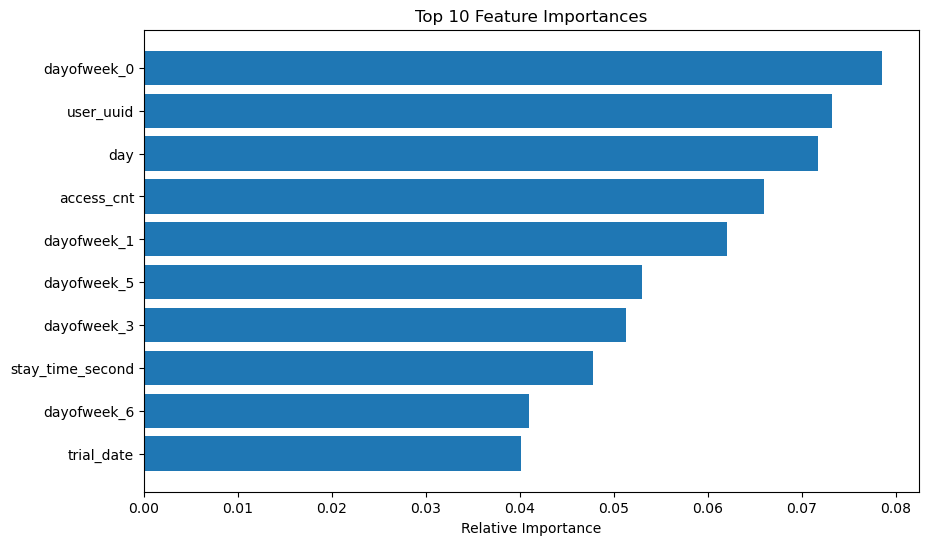

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 피처 중요도 추출
importances = best_model.named_steps['xgbclassifier'].feature_importances_

# 피처 이름 정의 (여기서는 X_train 데이터 프레임의 컬럼명을 사용)
feature_names = pd.DataFrame(x_train, columns=share_data.drop(columns=['is_payment']).columns).columns

# 피처 중요도 정렬 후 상위 10개 선택
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



In [153]:
print(len(feature_names))
print(len(feature_importances))

28
21


In [154]:
share_data

,Unnamed: 0,is_payment,user_uuid,trial_date,day,access_cnt,stay_time_second,dayofweek_0,dayofweek_1,dayofweek_2,...,office_area_150.0,site_id_1.0,site_id_2.0,site_id_3.0,site_id_4.0,site_id_5.0,site_id_6.0,site_id_17.0,site_id_47.0,site_id_49.0
0,0,0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21,-0.775964,0.195142,-0.376638,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21,0.791066,-0.680311,-0.710421,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,2,1,4a184795-b056-4572-a874-644f68609ea3,2023-12-21,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21,-0.775964,-0.789743,-0.957817,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21,-0.775964,-0.570880,-0.947543,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,9619,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023-11-17,0.791066,2.383776,1.617236,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
9620,9620,0,43263092-3b28-4817-9fa9-4205ad3097fe,2023-11-17,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9621,9621,0,51a40f33-1027-4544-9b95-45bca7c104fb,2023-11-17,0.791066,0.304574,2.304369,1.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
9622,9622,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023-11-18,-0.775964,-0.461448,-0.081284,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0


## it 기업 창업 기업 수와 현재 데이터 비교

In [155]:
create_df = pd.read_excel('업종별_창업기업수_20250304142203.xlsx')

In [156]:
create_df 

,업종별(1),업종별(2),2024.09,2024.1,2024.11,2016.1/4,2016.2/4,2016.3/4,2016.4/4,2017.1/4,...,2022.2/4,2022.3/4,2022.4/4,2023.1/4,2023.2/4,2023.3/4,2023.4/4,2024.1/4,2024.2/4,2024.3/4
0,서비스업,정보통신업,2781,3180,2958,5608,5765,5398,5638,5930,...,12702,10731,10815,13375,10276,9376,11843,10901,10322,9502


In [157]:
create_df = create_df.drop(columns=['업종별(1)','업종별(2)'])

In [158]:
create_df = create_df.transpose()

In [159]:
create_df = create_df.rename(columns={0 : 'count'})

In [160]:
create_df=create_df.reset_index()

In [161]:
create_df = create_df.rename(columns={'index' : 'quarter'})

### 분기 별 창업 기업 수 분포 

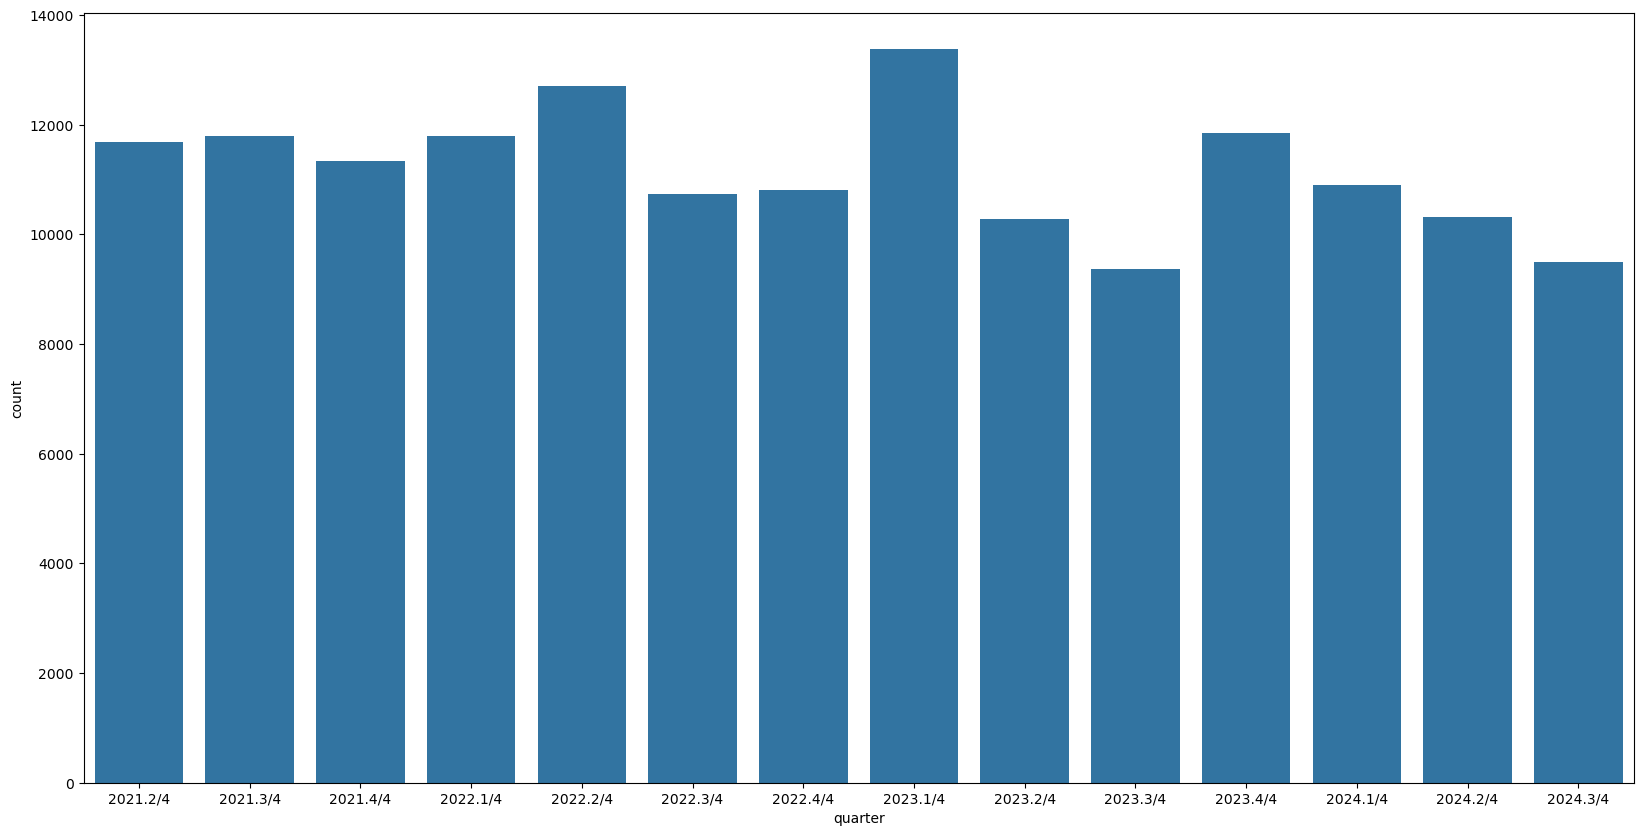

In [162]:
plt.figure(figsize=(20,10))
sns.barplot(data=create_df.iloc[24 :], x='quarter', y='count')
plt.show()

In [163]:
create_quarter = create_df.iloc[24 :]

In [164]:
trial_register['trial_date'] = pd.to_datetime(trial_register['trial_date'])

In [165]:
trial_register['quarter'] = trial_register['trial_date'].dt.to_period('Q')
trial_register.head()

,trial_date,user_uuid,quarter
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,2023Q4
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023Q4
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,2023Q4
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023Q4
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023Q4


In [166]:
quarter_register = trial_register.groupby('quarter')[['user_uuid']].count()

### 분기 별 무료 체험 신청자 분포

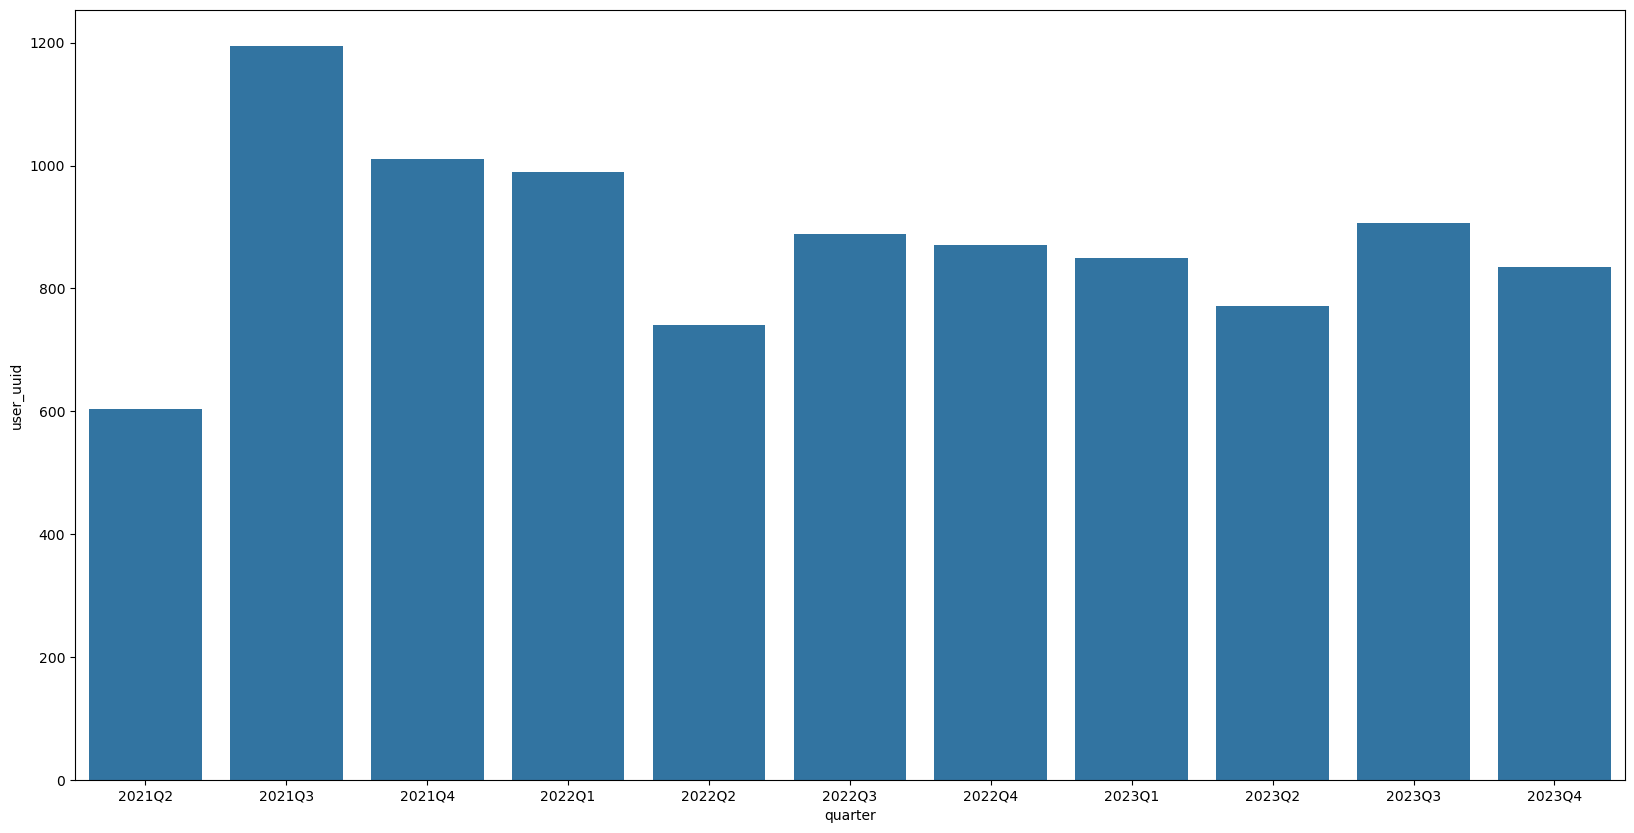

In [167]:
plt.figure(figsize=(20,10))
sns.barplot(quarter_register,x='quarter',y='user_uuid')
plt.show()

In [168]:
quarter_register = quarter_register.reset_index()

In [169]:
quarter = pd.concat([quarter_register,create_quarter],axis = 1)

In [170]:


# 데이터 분할
df1 = quarter.iloc[:11]  # 0번 행부터 10번 행까지 (기존 데이터)
df2 = quarter.iloc[11:]  # 11번 행부터 끝까지 (추가 데이터)

# 첫 번째 quarter 칼럼 제거
df1 = df1.drop(columns=['quarter'])

# 두 데이터프레임 병합 (기준은 dummy_col 칼럼)
df_combined = pd.concat([df2.reset_index(drop=True), df1[['user_uuid', 'count']].reset_index(drop=True)], axis=1)

# NaN 값 처리 (0으로 대체)
df_combined = df_combined.fillna(0)
df_combined.head()


C:\Users\seonw\AppData\Local\Temp\ipykernel_24360\1478209388.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined = df_combined.fillna(0)


,quarter,user_uuid,quarter,count,user_uuid,count
0,0,0.0,2021.2/4,11686.0,604.0,0.0
1,0,0.0,2021.3/4,11796.0,1194.0,0.0
2,0,0.0,2021.4/4,11338.0,1011.0,0.0
3,0,0.0,2022.1/4,11793.0,990.0,0.0
4,0,0.0,2022.2/4,12702.0,740.0,0.0


In [171]:
df = df_combined.iloc[: , 2:]

In [172]:
df = df.iloc[ : 11, : 3]

### 무료 체험 신청자 수와 창업 기업 수 상관성 비교

회귀계수 (기울기): -0.009167676439061155
절편: 982.878284214509
평균 제곱 오차 (MSE): 21640.61113275297


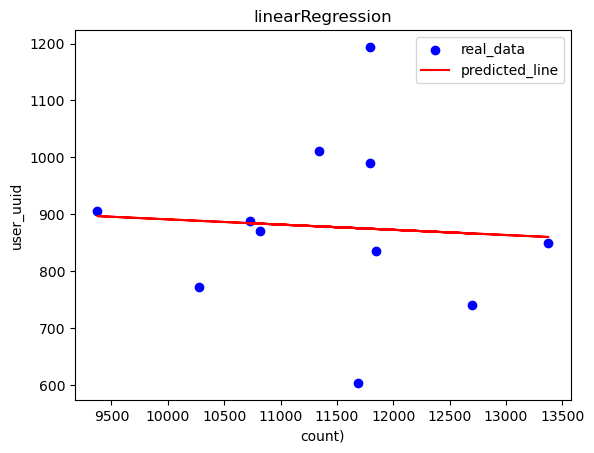

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 예제 데이터 생성

X = df[['count']]  # 독립 변수
Y = df['user_uuid']

# 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(X, Y)

# 회귀계수 및 절편 출력
print("회귀계수 (기울기):", model.coef_[0])
print("절편:", model.intercept_)

# 예측 및 성능 평가
Y_pred = model.predict(X)
mse = mean_squared_error(Y, Y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 시각화
plt.scatter(X, Y, color="blue", label="real_data")
plt.plot(X, Y_pred, color="red", label="predicted_line")
plt.legend()
plt.xlabel("count)")
plt.ylabel("user_uuid")
plt.title("linearRegression")
plt.show()


-0.009의 회귀 계수로 너무 낮다.  
상관성이 있다고 보기는 어려워 보인다. 아무래도 데이터 양이 적다 보니까 그런 것 같다.

In [174]:
share_data['trial_date']

0       2023-12-21
1       2023-12-21
2       2023-12-21
3       2023-12-21
4       2023-12-21
           ...    
9619    2023-11-17
9620    2023-11-17
9621    2023-11-17
9622    2023-11-18
9623    2023-11-18
Name: trial_date, Length: 9624, dtype: object

### 다른 데이터 가져오기(월 별 IT 창업 기업 수)

In [175]:
it_company = pd.read_csv('서울_창업_월별.csv', encoding='cp949').iloc[:, 3 :]
it_company = it_company.transpose()
it_company.head()

,0,1,2
2021.05,22977,4447,1212
2021.06,24226,4977,1272
2021.07,23118,4918,1319
2021.08,21963,4654,1307
2021.09,20921,4068,1084


In [176]:
it_company = it_company.rename(columns={0 : 'all', 1 : 'technology', 2 : 'IT'})

In [177]:
it_company.reset_index(inplace=True)

In [178]:
it_company.rename(columns={'index' : 'date'},inplace=True)

In [179]:
it_company.head()

,date,all,technology,IT
0,2021.05,22977,4447,1212
1,2021.06,24226,4977,1272
2,2021.07,23118,4918,1319
3,2021.08,21963,4654,1307
4,2021.09,20921,4068,1084


In [180]:
it_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        32 non-null     object
 1   all         32 non-null     int64 
 2   technology  32 non-null     int64 
 3   IT          32 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


In [181]:
it_company['date'] = pd.to_datetime(it_company['date']).dt.strftime('%Y.%m')

C:\Users\seonw\AppData\Local\Temp\ipykernel_24360\2390379066.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  it_company['date'] = pd.to_datetime(it_company['date']).dt.strftime('%Y.%m')


In [182]:
it_company.head()

,date,all,technology,IT
0,2021.05,22977,4447,1212
1,2021.06,24226,4977,1272
2,2021.07,23118,4918,1319
3,2021.08,21963,4654,1307
4,2021.09,20921,4068,1084


### 월 별 창업 기업 수 분포

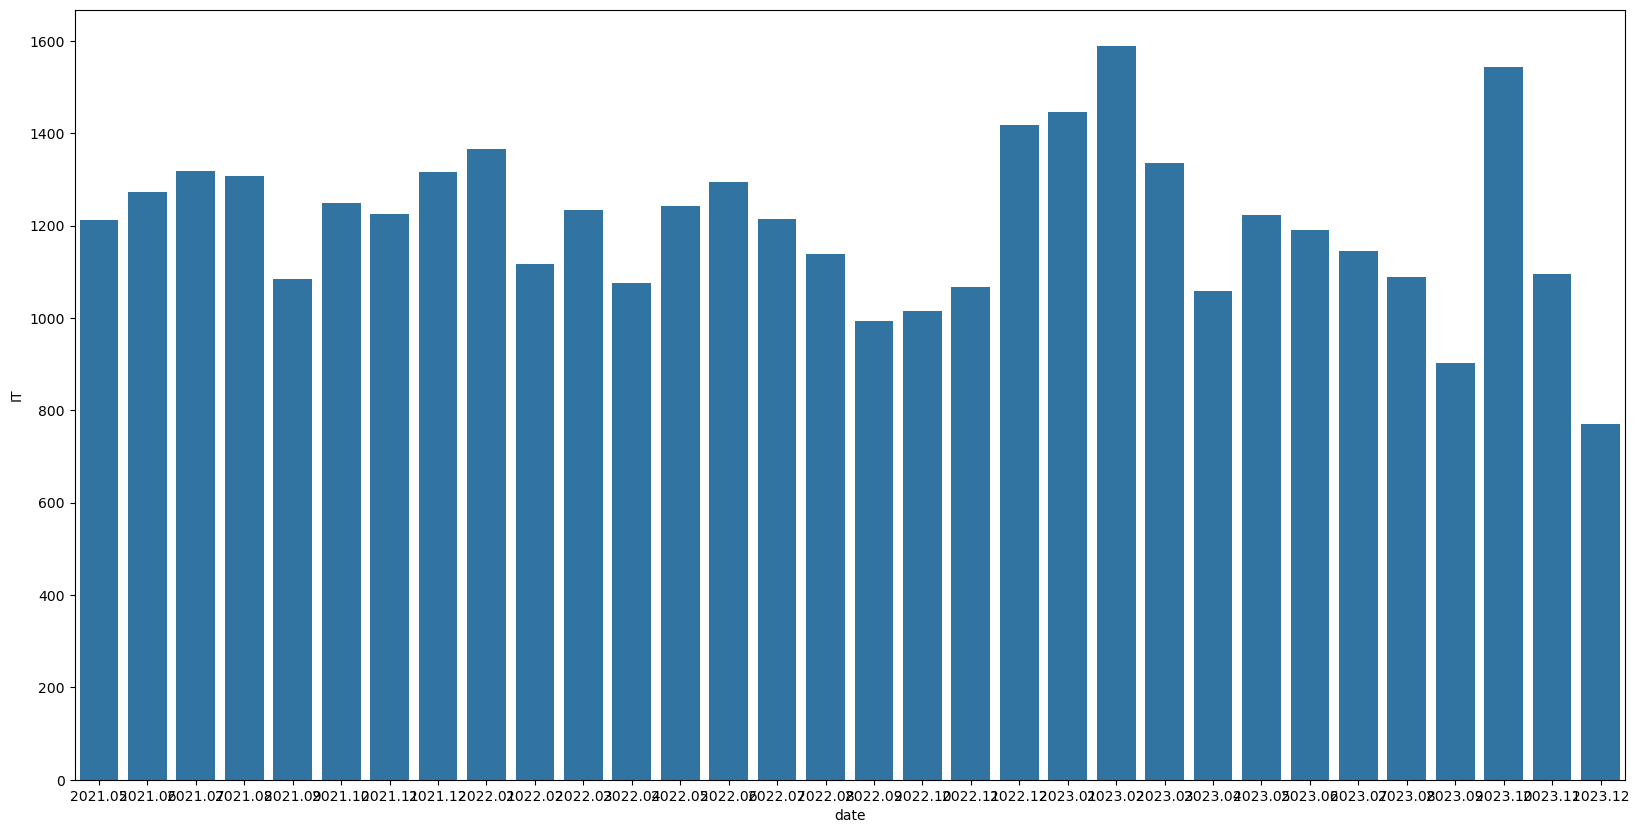

In [183]:
plt.figure(figsize=(20,10))
sns.barplot(it_company,x='date',y='IT')
plt.show()

In [184]:

# 연.월 형식으로 변환
trial_register['year_month'] = trial_register['trial_date'].dt.strftime('%Y.%m')

trial_register.head()


,trial_date,user_uuid,quarter,year_month
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,2023Q4,2023.12
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023Q4,2023.12
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,2023Q4,2023.12
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023Q4,2023.12
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023Q4,2023.12


In [185]:
month_register = trial_register.groupby('year_month')[['user_uuid']].count()

In [186]:
month_register.head()

,user_uuid
year_month,
2021.05,282
2021.06,322
2021.07,357
2021.08,354
2021.09,483


### 월 별 무료 체험 등록 수 분포

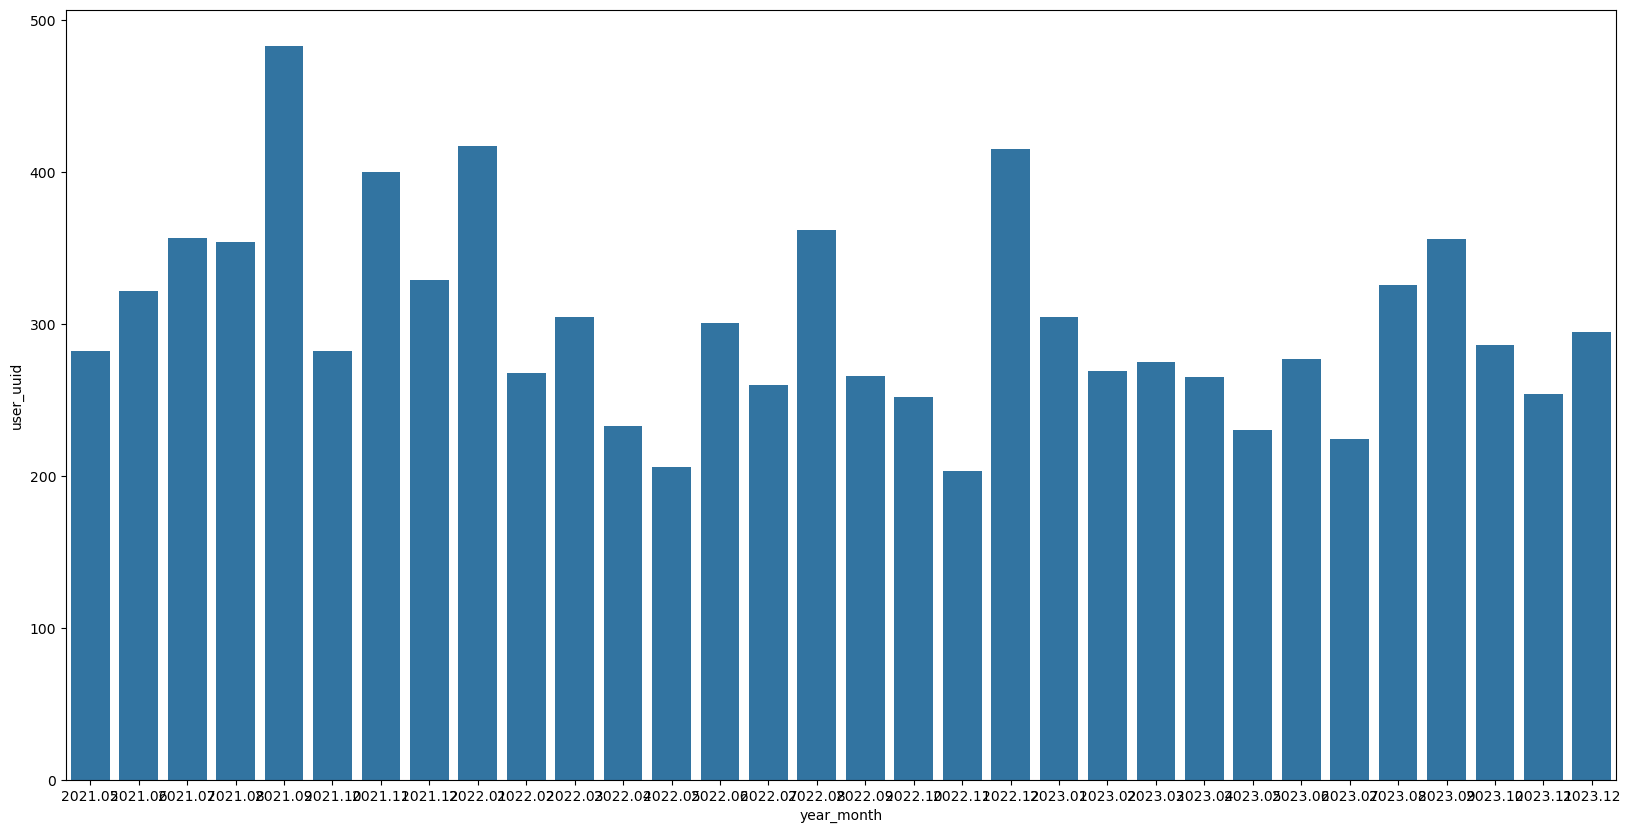

In [187]:
plt.figure(figsize=(20,10))
sns.barplot(month_register,x='year_month',y='user_uuid')
plt.show()

### 월 별 무료 체험 신청 수와 창업 기업 수 상관성 비교

In [188]:
from scipy.stats import pearsonr

# 피어슨 상관계수 계산
correlation, p_value = pearsonr(month_register['user_uuid'],it_company['IT'])

# 결과 출력
print(f"피어슨 상관계수: {correlation}")
print(f"P-값: {p_value}")


피어슨 상관계수: 0.1416681449491891
P-값: 0.4392710115230185


p_value = 0.4392710115230185
회귀 계수 = 0.37769313936201176
절편 = 1090.5894364656979


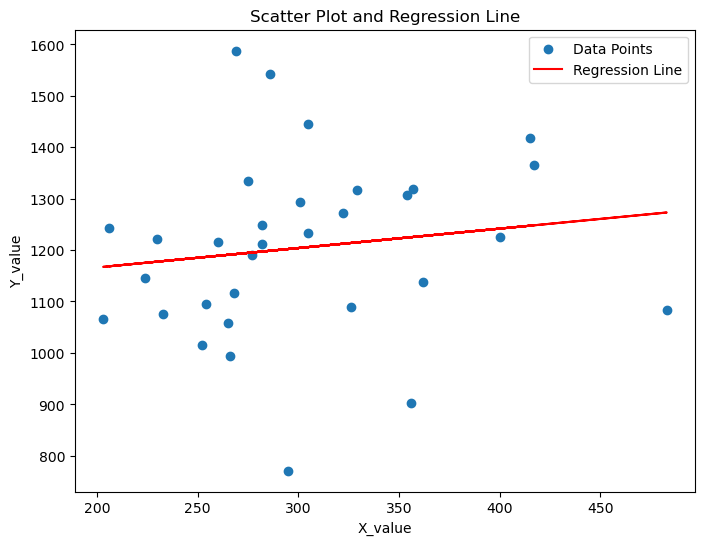

In [189]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt

x = month_register['user_uuid']
y = it_company['IT']

# 3. 산점도 및 회귀선 시각화
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept
print(f"p_value = {p_value}")
print(f"회귀 계수 = {slope}")
print(f"절편 = {intercept}")
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points')
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.xlabel('X_value')
plt.ylabel('Y_value')
plt.title('Scatter Plot and Regression Line')
plt.legend()
plt.show()


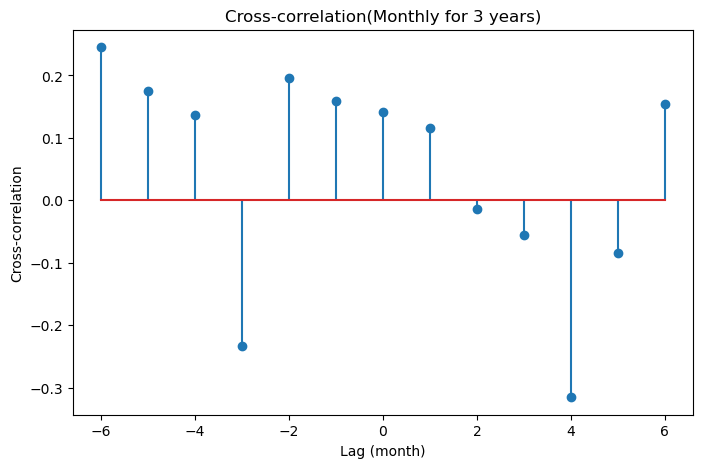

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = month_register['user_uuid']
y = it_company['IT']

# 교차 상관계수 계산 함수 (lag가 음수와 양수 모두 고려)
def cross_correlation(a, b, lag):
    if lag < 0:
        return np.corrcoef(a[:lag], b[-lag:])[0, 1]
    elif lag > 0:
        return np.corrcoef(a[lag:], b[:-lag])[0, 1]
    else:
        return np.corrcoef(a, b)[0, 1]

# 적절한 lag 범위 설정 (예: -6개월 ~ +6개월)
lags = range(-6, 7)
corrs = [cross_correlation(x, y, lag) for lag in lags]

plt.figure(figsize=(8, 5))
plt.stem(lags, corrs)
plt.xlabel('Lag (month)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation(Monthly for 3 years)')
plt.show()

무료 신청자 수는 창업 기업 수가 증가하는 시점 4개월 뒤에 가장 크게 감소하는(?) 경향이 보인다

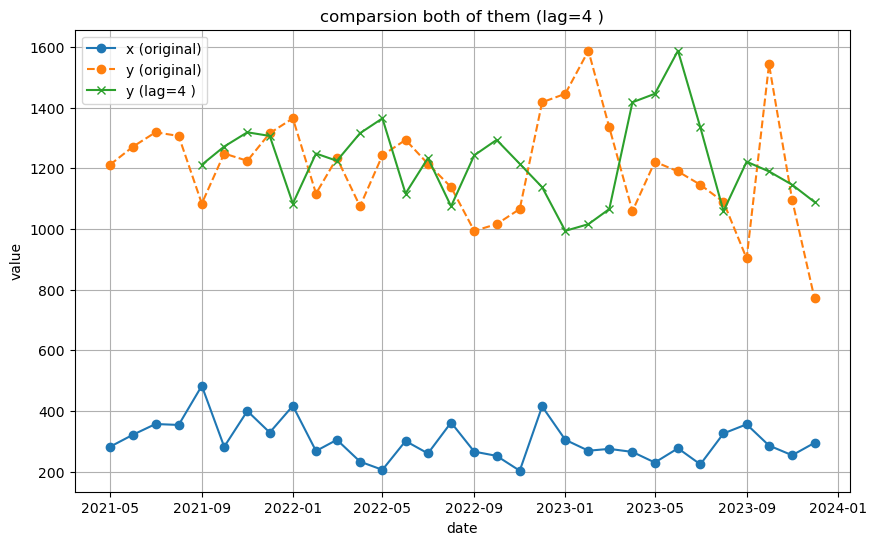

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 3년치 월별 날짜 생성 (예: 2020-01부터 2022-12까지)
dates = pd.date_range(start='2021-05', periods=32, freq='MS')

x = month_register['user_uuid']
y = it_company['IT']
# lag 설정 (4개월)
lag = 4
# y를 lag 만큼 이동 (앞부분은 NaN으로 채움)
y_shifted = np.empty(len(y),dtype=float)
y_shifted[:lag] = np.nan
y_shifted[lag:] = y[:-lag]

plt.figure(figsize=(10, 6))
plt.plot(dates, x, marker='o', label='x (original)')
plt.plot(dates, y, marker='o', linestyle='--', label='y (original)')
plt.plot(dates, y_shifted, marker='x', linestyle='-', label=f'y (lag={lag} )')
plt.xlabel('date')
plt.ylabel('value')
plt.title(f'comparsion both of them (lag={lag} )')
plt.legend()
plt.grid(True)
plt.show()

기간 별로 it 기업 창업 수와 비교한 결과 4개월이 지나면 창업 수와 무료 신청자 수 간에  음의 관계로 절댓값이 가장 큰 상관관계를 가지는 시점이다. 
그래서 4개월 그 즈음부터 많은 창업 기업들이 공유오피스 사용을 더이상 하지 않는다.

### 월 별 유로 전환률 비교 데이터 생성

In [192]:
trial_register_drop = trial_register.drop_duplicates(subset='user_uuid')

In [193]:
trial_register_drop

,trial_date,user_uuid,quarter,year_month
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,2023Q4,2023.12
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023Q4,2023.12
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,2023Q4,2023.12
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023Q4,2023.12
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023Q4,2023.12
...,...,...,...,...
9654,2023-11-17,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,2023Q4,2023.11
9655,2023-11-17,43263092-3b28-4817-9fa9-4205ad3097fe,2023Q4,2023.11
9656,2023-11-17,51a40f33-1027-4544-9b95-45bca7c104fb,2023Q4,2023.11
9657,2023-11-18,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,2023Q4,2023.11


In [194]:
trial_payment_drop

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0
...,...,...
9654,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655,0,43263092-3b28-4817-9fa9-4205ad3097fe
9656,0,51a40f33-1027-4544-9b95-45bca7c104fb
9657,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c


In [195]:
register_payment = pd.merge(trial_register_drop, trial_payment_drop, on='user_uuid', how='inner')

In [196]:
register_payment.head()

,trial_date,user_uuid,quarter,year_month,is_payment
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,2023Q4,2023.12,0
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023Q4,2023.12,0
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,2023Q4,2023.12,1
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023Q4,2023.12,0
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023Q4,2023.12,0


In [197]:
month_is_payment = register_payment.groupby('year_month')[['is_payment']].mean()

In [198]:
month_is_payment.to_csv('month_is_payment.csv')

In [199]:
month_is_payment.head()

,is_payment
year_month,
2021.05,0.503546
2021.06,0.529595
2021.07,0.434174
2021.08,0.384181
2021.09,0.397516


### 월 별 유료 결제율과 창업 기업 수 상관성 분석

In [200]:
from scipy.stats import pearsonr

# 피어슨 상관계수 계산
correlation, p_value = pearsonr(it_company['IT'],month_is_payment['is_payment'])

# 결과 출력
print(f"피어슨 상관계수: {correlation}")
print(f"P-값: {p_value}")


피어슨 상관계수: 0.2138573320155207
P-값: 0.23988028923085447


p-value가 높기 때문에 통계적으로 유의미하다라고 생각할 수는 없지만 어느 정도 상관성인 있는 걸로 보인다.

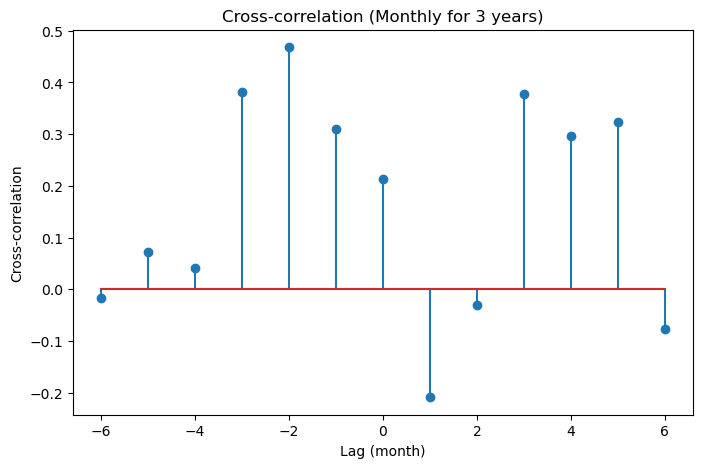

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = month_is_payment['is_payment']
y = it_company['IT']

# 교차 상관계수 계산 함수 (lag가 음수와 양수 모두 고려)
def cross_correlation(a, b, lag):
    if lag < 0:
        return np.corrcoef(a[:lag], b[-lag:])[0, 1]
    elif lag > 0:
        return np.corrcoef(a[lag:], b[:-lag])[0, 1]
    else:
        return np.corrcoef(a, b)[0, 1]

# 적절한 lag 범위 설정 (예: -6개월 ~ +6개월)
lags = range(-6, 7)
corrs = [cross_correlation(x, y, lag) for lag in lags]

plt.figure(figsize=(8, 5))
plt.stem(lags, corrs)
plt.xlabel('Lag (month)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation (Monthly for 3 years)')
plt.show()

lag = -2일 때 상관계수가 가장 높다는 것은, IT 창업 기업 수가 두 달 후에 공유 오피스의 유료 전환율에 긍정적인 영향을 미칠 가능성을 시사한다. 즉, 새로운 IT 창업 기업이 증가한 후 약 2개월이 지난 시점에서 공유 오피스를 유료로 전환하는 고객(기업)이 증가할 가능성이 있다는 의미로 해석할 수 있다.

p_value = 0.23988028923085453
회귀 계수 = 8.269976100948465e-05
절편 = 0.2803197657227874


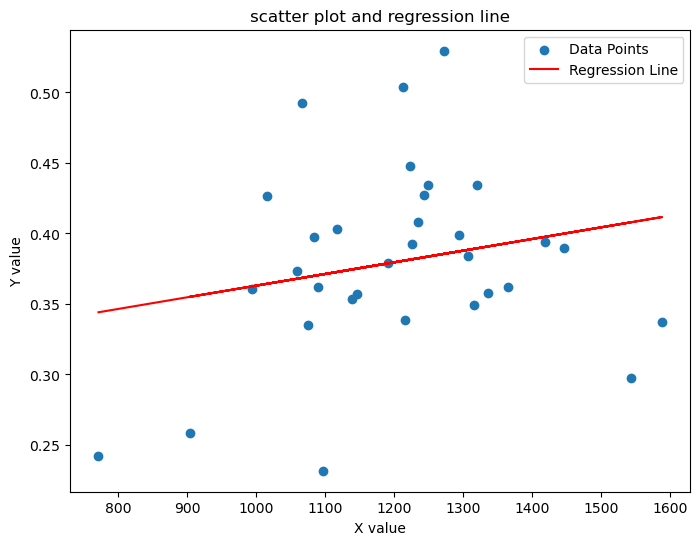

In [202]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt

x = it_company['IT']
y = month_is_payment['is_payment']

# 3. 산점도 및 회귀선 시각화
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept
print(f"p_value = {p_value}")
print(f"회귀 계수 = {slope}")
print(f"절편 = {intercept}")
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points')
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.title('scatter plot and regression line')
plt.legend()
plt.show()

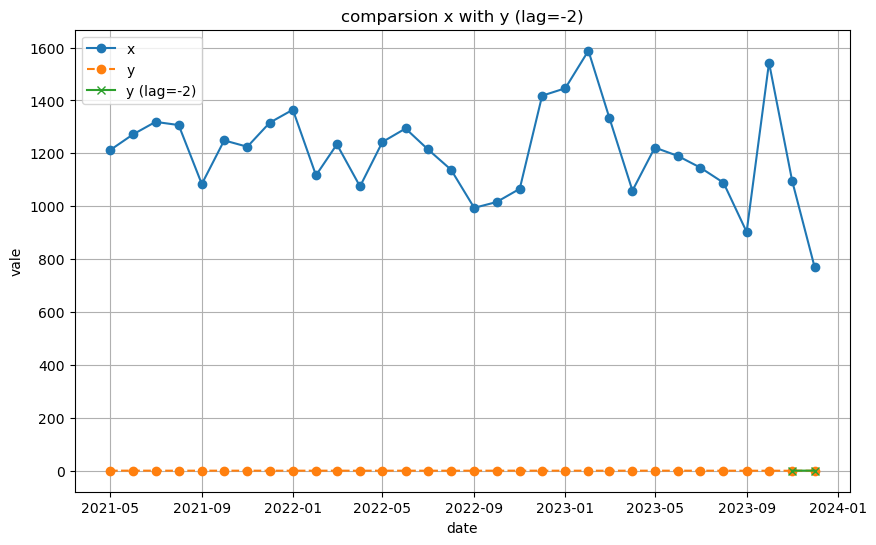

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 3년치 월별 날짜 생성 (예: 2020-01부터 2022-12까지)
dates = pd.date_range(start='2021-05', periods=32, freq='MS')

x = it_company['IT']
y = month_is_payment['is_payment']
# lag 설정 (4개월)
lag = -2
# y를 lag 만큼 이동 (앞부분은 NaN으로 채움)
y_shifted = np.empty(len(y),dtype=float)
y_shifted[:lag] = np.nan
y_shifted[lag:] = y[:-lag]

plt.figure(figsize=(10, 6))
plt.plot(dates, x, marker='o', label='x')
plt.plot(dates, y, marker='o', linestyle='--', label='y')
plt.plot(dates, y_shifted, marker='x', linestyle='-', label=f'y (lag={lag})')
plt.xlabel('date')
plt.ylabel('vale')
plt.title(f'comparsion x with y (lag={lag})')
plt.legend()
plt.grid(True)
plt.show()

값의 차이가 있어서 시각화로는 분포를 발견하기가 어렵다

### 창업 기업 수 정규화 진행  
데이터 시각화에서 분포를 통한 인사이트를 얻기 위해 정규화를 진행해서 결제율과 비슷한 수치로 만든다.

In [204]:
it_df = it_company[['date','IT']]

In [205]:
import numpy as np

# 예제 데이터
data = np.array([10, 20, 30, 40, 50])

# 정규화
normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
print(normalized_data)


[0.   0.25 0.5  0.75 1.  ]


In [206]:
it_df.head()

,date,IT
0,2021.05,1212
1,2021.06,1272
2,2021.07,1319
3,2021.08,1307
4,2021.09,1084


In [207]:
# it 창업 기업 수 정규화 진행
it_df['IT'] = (it_df['IT'] - np.min(it_df['IT'])) / (np.max(it_df['IT']) - np.min(it_df['IT']))

C:\Users\seonw\AppData\Local\Temp\ipykernel_24360\3405233101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  it_df['IT'] = (it_df['IT'] - np.min(it_df['IT'])) / (np.max(it_df['IT']) - np.min(it_df['IT']))


### 정규화 된 데이터와 비교 분석

In [208]:
from scipy.stats import pearsonr

# 피어슨 상관계수 계산
correlation, p_value = pearsonr(it_df['IT'],month_is_payment['is_payment'])

# 결과 출력
print(f"피어슨 상관계수: {correlation}")
print(f"P-값: {p_value}")

피어슨 상관계수: 0.21385733201552076
P-값: 0.23988028923085447


p_value = 0.23988028923085453
회귀 계수 = 0.06756570474474896
절편 = 0.34408128146110006


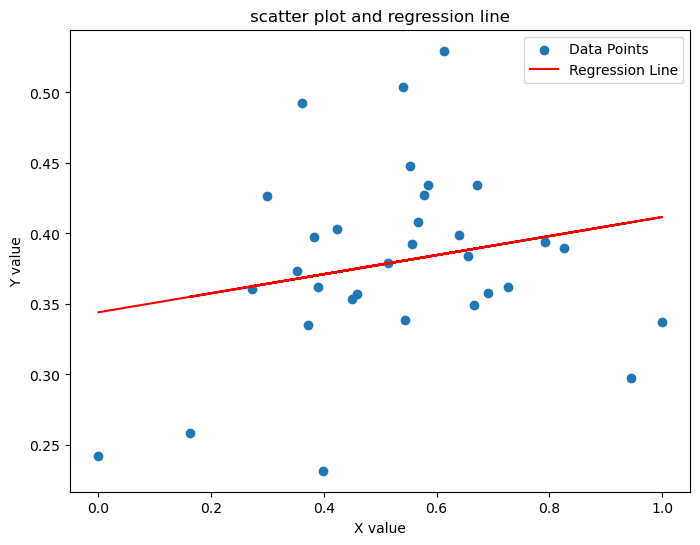

In [209]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt

x = it_df['IT']
y = month_is_payment['is_payment']

# 3. 산점도 및 회귀선 시각화
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept
print(f"p_value = {p_value}")
print(f"회귀 계수 = {slope}")
print(f"절편 = {intercept}")
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points')
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.title('scatter plot and regression line')
plt.legend()
plt.show()

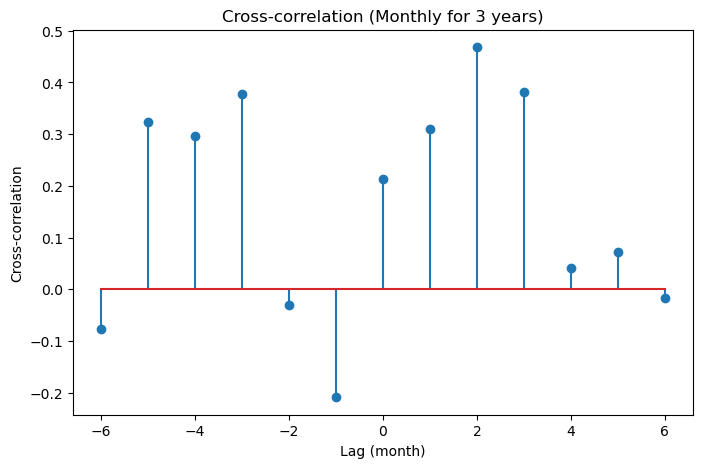

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = it_df['IT']
y = month_is_payment['is_payment']

# 교차 상관계수 계산 함수 (lag가 음수와 양수 모두 고려)
def cross_correlation(a, b, lag):
    if lag < 0:
        return np.corrcoef(a[:lag], b[-lag:])[0, 1]
    elif lag > 0:
        return np.corrcoef(a[lag:], b[:-lag])[0, 1]
    else:
        return np.corrcoef(a, b)[0, 1]

# 적절한 lag 범위 설정 (예: -6개월 ~ +6개월)
lags = range(-6, 7)
corrs = [cross_correlation(x, y, lag) for lag in lags]

plt.figure(figsize=(8, 5))
plt.stem(lags, corrs)
plt.xlabel('Lag (month)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation (Monthly for 3 years)')
plt.show()

IT 창업 기업 수의 증가는 두 달 후 공유 오피스 유료 전환율의 증가로 이어질 가능성이 있다. 이는 IT 창업 기업이 설립 초기에는 업무 공간에 대한 니즈가 크지 않다가, 시간이 지나면서 공유 오피스 공간을 활용하는 경향이 생길 수 있음을 나타낸다.

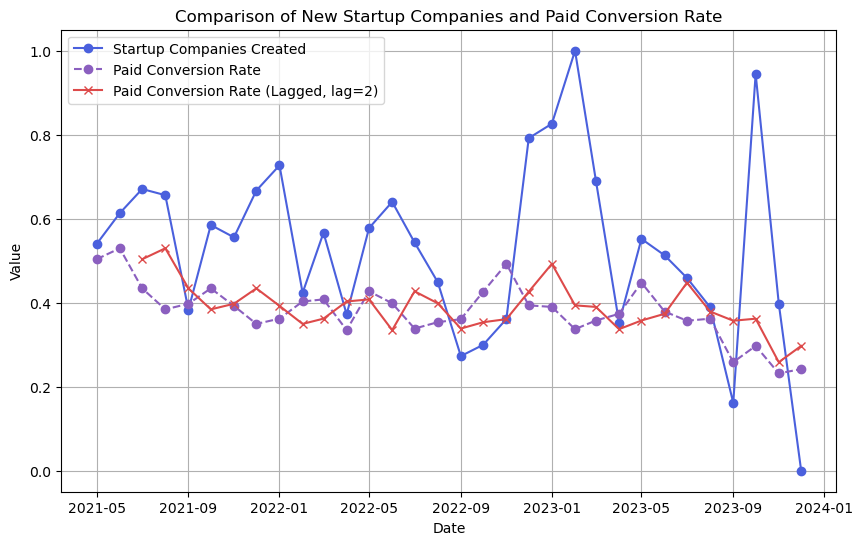

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 3년치 월별 날짜 생성 (예: 2020-01부터 2022-12까지)
dates = pd.date_range(start='2021-05', periods=32, freq='MS')

x = it_df['IT']
y = month_is_payment['is_payment']
# lag 설정 (4개월)
lag = 2
# y를 lag 만큼 이동 (앞부분은 NaN으로 채움)
y_shifted = np.empty(len(y), dtype=float)
y_shifted[:lag] = np.nan
y_shifted[lag:] = y[:-lag]

plt.figure(figsize=(10, 6))
plt.plot(dates, x, marker='o', color='#4a60dd', label='Startup Companies Created')  # 선 색상 #4a60dd
plt.plot(dates, y, marker='o', linestyle='--', color='#8b5fbf', label='Paid Conversion Rate')  # 보라색 계열
plt.plot(dates, y_shifted, marker='x', linestyle='-', color='#dd4a4a', label=f'Paid Conversion Rate (Lagged, lag={lag})')  # 빨간색 계열
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of New Startup Companies and Paid Conversion Rate')  # 제목 수정
plt.legend()
plt.grid(True)
plt.show()


창업 기업 수가 늘어나면 2달 뒤에 공유 오피스 유로 전환율 또한 약간의 상승이라도 보인다.  
어느 정도 상관성은 있는 것으로 사료된다.

IT 창업 기업 수의 증가는 두 달 후 공유 오피스 유료 전환율의 증가로 이어질 가능성이 있다. 이는 IT 창업 기업이 설립 초기에는 업무 공간에 대한 니즈가 크지 않다가, 시간이 지나면서 공유 오피스 공간을 활용하는 경향이 생길 수 있음을 나타낸다.